In [17]:
%pip install synthcity[all]
%pip install catenets
%pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 63.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 7.0 MB/s eta 0:00:00
     ━━━

In [1]:
from synthcity.plugins import Plugins
from synthcity.metrics.eval_statistical import AlphaPrecision, InverseKLDivergence, MaximumMeanDiscrepancy, WassersteinDistance
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.utils.serialization import save_to_file, load_from_file
import matplotlib.pyplot as plt
import pandas as pd
from catenets.models.torch import *
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup
import numpy as np
from sklearn.metrics import mean_squared_error
from os import listdir
from sklearn.preprocessing import OneHotEncoder
from captum.attr import *
import torch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import multivariate_normal
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from synthcity.plugins.core.constraints import Constraints
import random


[KeOps] Warning : There were warnings or errors :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:16:10: fatal error: cuda.h: No such file or directory
 #include <cuda.h>
          ^~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warn

In [2]:
def train_models(gen_list, datasets, n_runs):
    for g in gen_list:
        for dataset in datasets:
            for i in range(n_runs):
                print(f'Training model {g} iteration {i} on dataset {dataset}')
                model = Plugins().get(g)
                model.fit(datasets[dataset])
                fp = 'models/' + g + '_' + dataset + '_' + str(i) + '.pkl'
                print(f'Saving model {g} iteration {i} on dataset {dataset}')
                save_to_file(fp, model)

In [3]:
def generate_data(models, n):
    for fp in models:
        g = load_from_file('models/' + fp)
        df = g.generate(count = n).dataframe()

        name_list = fp.split('.')
        name = name_list[0]
        df.to_csv('syn_data/' + name + '.csv', index=False)

In [4]:
def get_CATE_PEHE(datasets, X_t, mu0, mu1, outcome_col, treatment_col, include_S = True):
    results = pd.DataFrame(columns=['generator', 'learner', 'rmse'])
    for d in datasets:
        dataset = datasets[d]
        X = np.array(dataset.drop([treatment_col, outcome_col], axis=1))
        y = np.array(dataset[outcome_col])
        w = np.array(dataset[treatment_col])  
        if include_S:
            learners = [TNet(), SNet(), PWNet(), RANet(), DRNet()]
        else:
            learners = [TNet(), PWNet(), RANet(), DRNet()]

        for learner in learners:
            learner.fit(X,y,w)
            pred = learner.predict(X_t)
            cate = mu1 - mu0
            rmse = mean_squared_error(cate, pred, squared = False)
            results.loc[len(results.index)] = [d, learner.__str__(), rmse]
            print(f'{learner} complete on {d}')

    return results

In [5]:
def get_CATE_estimates(training_datasets, X_t, mu0, mu1, outcome_col, treatment_col, include_S = True):
    results = X_t.copy()
    results = pd.concat([results, mu0, mu1], axis=1)
    results['CATE'] = results['mu1'] - results['mu0']

    for d in training_datasets:
        dataset = training_datasets[d]
        X = np.array(dataset.drop([treatment_col, outcome_col], axis=1))
        y = np.array(dataset[outcome_col])
        w = np.array(dataset[treatment_col])

        if include_S:
            learners = [TNet(), SNet(), PWNet(), RANet(), DRNet()]
        else:
            learners = [TNet(), PWNet(), RANet(), DRNet()]

        for learner in learners:
            learner.fit(X,y,w)
            X_t_array = np.array(X_t)
            pred = learner.predict(X_t_array)
            col = d.split('.')[0] + '_' + learner.__str__()
            results[col] = pred
        
            print(f'{learner} complete on {d}')
            
    return results

In [6]:
def rate_of_flipping(d, cols):
    rates = pd.DataFrame()
    for c in cols:
        m = d['CATE'] * d[c]
        wrong = sum(m<0)
        rate = wrong / d.shape[0]
        rates[c] = [rate]
    rates = rates.transpose()
    return rates

In [7]:
def standard_metrics(datasets, real, metrics):
    results = pd.DataFrame(columns = ['dataset', 'metric', 'result'])
    for d in datasets:
        dataset = GenericDataLoader(datasets[d])
        for m in metrics:
            metric = metrics[m]
            result = metric.evaluate(real, dataset)
            for r in result:
                results.loc[len(results.index)] = [d, r, result[r]]
    
    return results

In [8]:
def encode_acic_datasets(real, syn_data):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)

    syn_data_encoded = {}
    for d in syn_data:
        syn_dataset = syn_data[d]
        encoded = encoder.transform(syn_dataset[categorical])
        encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
        syn_encoded = pd.concat([syn_dataset, encoded_df], axis=1)
        syn_encoded.drop(categorical, axis=1, inplace=True)
        syn_data_encoded[d] = syn_encoded
    
    return real_encoded, syn_data_encoded

In [9]:
def encode_acic(real, syn_dataset):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)
    encoded = encoder.transform(syn_dataset[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    syn_encoded = pd.concat([syn_dataset, encoded_df], axis=1)
    syn_encoded.drop(categorical, axis=1, inplace=True)
    return real_encoded, syn_encoded

## New metrics

In [10]:
def covariate_fidelity(real, syn_data, treatment_col, outcome_col, save=False, fp=''):
    alpha = AlphaPrecision()
    results = pd.DataFrame(columns = ['dataset', 'f0', 'f1', 'covariate fidelity'])

    for d in syn_data:
        real_0 = real[real[treatment_col] == 0].drop([treatment_col, outcome_col], axis=1)
        real_1 = real[real[treatment_col] == 1].drop([treatment_col, outcome_col], axis=1)

        n_0 = len(real_0)
        n_1 = len(real_1)
        synth = syn_data[d]
        synth_0 = synth[synth[treatment_col] == 0].drop([treatment_col, outcome_col], axis=1)
        synth_1 = synth[synth[treatment_col] == 1].drop([treatment_col, outcome_col], axis=1)

        s_0 = len(synth_0)
        s_1 = len(synth_1)

        if n_0 <= s_0:
            synth_0 = synth_0[0:n_0]
        else:
            real_0 = real_0[0:s_0]

        if n_1 <= s_1:
            synth_1 = synth_1[0:n_1]
        else:
            real_1 = real_1[0:s_1]

        f0 = alpha.evaluate(GenericDataLoader(real_0), GenericDataLoader(synth_0))['delta_precision_alpha_OC']
        f1 = alpha.evaluate(GenericDataLoader(real_1), GenericDataLoader(synth_1))['delta_precision_alpha_OC']
        pi = n_0 / (n_0 + n_1)

        f = pi * f1 + (1-pi)*f0
        results.loc[len(results)] = [d, f0, f1, f]
    
    if save:
        results.to_csv(fp, index=False)
    return results


In [11]:
def evaluate_f(real, synth, treatment_col, outcome_col):
    alpha = AlphaPrecision(random_state = random.randint(0, 1000000))

    real_0 = real[real[treatment_col] == 0].drop([treatment_col, outcome_col], axis=1)
    real_1 = real[real[treatment_col] == 1].drop([treatment_col, outcome_col], axis=1)
    n_0 = len(real_0)
    n_1 = len(real_1)
    synth_0 = synth[synth[treatment_col] == 0].drop([treatment_col, outcome_col], axis=1)
    synth_1 = synth[synth[treatment_col] == 1].drop([treatment_col, outcome_col], axis=1)
    s_0 = len(synth_0)
    s_1 = len(synth_1)

    if n_0 <= s_0:
        synth_0 = synth_0[0:n_0]
    else:
        real_0 = real_0[0:s_0]

    if n_1 <= s_1:
        synth_1 = synth_1[0:n_1]
    else:
        real_1 = real_1[0:s_1]

    f0 = alpha.evaluate(GenericDataLoader(real_0), GenericDataLoader(synth_0))['delta_precision_alpha_OC']
    f1 = alpha.evaluate(GenericDataLoader(real_1), GenericDataLoader(synth_1))['delta_precision_alpha_OC']
    pi = n_0 / (n_0 + n_1)

    return pi * f1 + (1-pi)*f0

In [12]:
def propensity_distance(p_real, p_synth):
    return 1 - abs(p_synth - p_real) / max(p_real, 1-p_real)

In [13]:
def propensity_matching(real, syn_data, treatment_col, outcome_col, cov_columns, save=False, fp=''):
    #need to deal with continuous
    results = pd.DataFrame(columns = ['dataset', 'D'])
    real = real.drop(outcome_col, axis=1)
    real_covariates = real.drop_duplicates(cov_columns).reset_index(drop=True)[cov_columns]

    for d in syn_data:

        synth = syn_data[d]
        total_p_dist = 0

        for index, condition in real_covariates.iterrows():

            matches = [real[i] == condition[i] for i in cov_columns]
            match = matches[0]
            
            for series in matches[1:]:
                match &= series

            p_real = sum(real[match][treatment_col]) / len(real[match])
            matches = [synth[i] == condition[i] for i in cov_columns]
            match = matches[0]

            for series in matches[1:]:
                match &= series

            if len(synth[match]) == 0:
                p_synth = 0
            else:
                p_synth = sum(synth[match][treatment_col]) / len(synth[match])
            total_p_dist += propensity_distance(p_real, p_synth)

        avg_p_dist = total_p_dist / len(real_covariates)
        results.loc[len(results)] = [d, avg_p_dist]

    if save:
        results.to_csv(fp, index=False)
    return results

In [14]:
def train_propensity_function(real, treatment_col, outcome_col):
    X = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real[treatment_col])
    classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    classifier.fit(X, y)

    return classifier

In [15]:
def get_d_max(props):
    propensities_max = [0 if i >= 0.5 else 1 for i in props]

    return mean_squared_error(props, propensities_max, squared=False)

In [16]:
def evaluate_d(real, synth, treatment_col, outcome_col):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    pi_real = train_propensity_function(real, treatment_col, outcome_col)
    pi_synth = train_propensity_function(synth, treatment_col, outcome_col)

    #should we be testing across some real test set, not the whole real?? yes
    probabilities_real = pi_real.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
    propensities_real = probabilities_real[:, 1]

    probabilities_synth = pi_synth.predict_proba(np.array(test.drop([treatment_col, outcome_col], axis=1)))
    propensities_synth = probabilities_synth[:, 1]

    d_max = get_d_max(propensities_real)

    return 1 - mean_squared_error(propensities_real, propensities_synth, squared=False)/d_max

In [17]:
def cosine_average_first(v1, v2):
    return cosine_similarity(v1.sum(axis=0).reshape(1,-1), v2.sum(axis=0).reshape(1,-1))[0][0]

In [18]:
def cosine_average_second(v1, v2):
    sims = [cosine_similarity(v1[[i]], v2[[i]])[0][0] for i in range(len(v1))]
    return sum(sims) / len(v1)

In [89]:
def evaluate_u_int(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]


    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    ig_real = IntegratedGradients(l_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    attr_real = ig_real.attribute(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    ig_synth = IntegratedGradients(l_synth)
    attr_synth = ig_synth.attribute(X_t)

    first, second = cosine_average_first(attr_real, attr_synth), cosine_average_second(attr_real, attr_synth)
    return first, second

In [90]:
def utility_int(real, synths, test, treatment_col, outcome_col, n_units, n_iter, save=False, save_name=''):
    results = pd.DataFrame(columns = ['dataset', 'first', 'second'])

    for _ in range(n_iter):
        l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)
        ig_real = IntegratedGradients(l_real)
        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        attr_real = ig_real.attribute(X_t)

        for s in synths:
            synth = synths[s]
            l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
            X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
            y_synth = np.array(synth[outcome_col])
            w_synth = np.array(synth[treatment_col])
            l_synth.fit(X_synth, y_synth, w_synth)
            ig_synth = IntegratedGradients(l_synth)
            attr_synth = ig_synth.attribute(X_t)

            first, second = cosine_average_first(attr_real, attr_synth), cosine_average_second(attr_real, attr_synth)
            results.loc[len(results)] = [s, first, second]

    if save:
        results.to_csv(f'utility_features_{save_name}.csv')
    
    return results

In [91]:
def evaluate_u_pehe(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    pred_real = l_real.predict(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    pred_synth = l_synth.predict(X_t)

    pehe = mean_squared_error(pred_real.cpu().detach().numpy(), pred_synth.cpu().detach().numpy(), squared=False)
    return pehe

In [92]:
def utility_pehe(real, synths, test, treatment_col, outcome_col, n_units, n_iter, save=False, save_name=''):
    results = pd.DataFrame(columns = ['dataset', 'pehe'])

    for _ in range(n_iter):
        l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)

        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        pred_real = l_real.predict(X_t)

        for s in synths:
            synth = synths[s]
            l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
            X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
            y_synth = np.array(synth[outcome_col])
            w_synth = np.array(synth[treatment_col])
            l_synth.fit(X_synth, y_synth, w_synth)
            
            pred_synth = l_synth.predict(X_t)

            pehe = mean_squared_error(pred_real.cpu().detach().numpy(), pred_synth.cpu().detach().numpy(), squared=False)
            results.loc[len(results)] = [s, pehe]

    if save:
        results.to_csv(f'utility_pehe_{save_name}.csv')
    
    return results

In [93]:
def evaluate_u_policy(real, synth, treatment_col, outcome_col, n_units):
    n = len(real)
    n_test = 0.2*n
    test = real[:round(n_test)]
    real = real[round(n_test):]

    l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
    y_real = np.array(real[outcome_col])
    w_real = np.array(real[treatment_col])
    l_real.fit(X_real, y_real, w_real)
    X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
    X_t = torch.tensor(X_t)
    pred_real = l_real.predict(X_t)

    l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
    X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
    y_synth = np.array(synth[outcome_col])
    w_synth = np.array(synth[treatment_col])
    l_synth.fit(X_synth, y_synth, w_synth)
    pred_synth = l_synth.predict(X_t)

    pred_mult = pd.DataFrame(pred_real * pred_synth)
    num_pos = len(pred_mult[pred_mult[0]>0])
    correct_rate = num_pos / len(pred_real)

    return correct_rate

In [94]:
def utility_policy(real, synths, test, treatment_col, outcome_col, n_units, n_iter, save=False, save_name=''):
    results = pd.DataFrame(columns = ['dataset', 'policy'])

    for _ in range(n_iter):
        l_real = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
        X_real = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y_real = np.array(real[outcome_col])
        w_real = np.array(real[treatment_col])
        l_real.fit(X_real, y_real, w_real)

        X_t = np.array(test.drop([treatment_col, outcome_col], axis=1))
        X_t = torch.tensor(X_t)
        pred_real = l_real.predict(X_t)

        for s in synths:
            synth = synths[s]
            l_synth = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
            X_synth = np.array(synth.drop([treatment_col, outcome_col], axis=1))
            y_synth = np.array(synth[outcome_col])
            w_synth = np.array(synth[treatment_col])
            l_synth.fit(X_synth, y_synth, w_synth)
            
            pred_synth = l_synth.predict(X_t)

            pred_mult = pd.DataFrame(pred_real * pred_synth)
            num_pos = len(pred_mult[pred_mult[0]>0])
            correct_rate = num_pos / len(pred_real)
            
            results.loc[len(results)] = [s, correct_rate]

    if save:
        results.to_csv(f'utility_policy_{save_name}.csv')
        
    return results

## Load real datasets

In [25]:
ihdp_full = pd.read_csv('../Datasets/ihdp.csv')
ihdp = ihdp_full.drop(['y_cfactual', 'mu0', 'mu1'], axis=1)
ihdp['treatment'] = ihdp['treatment'].astype(int)
#train on 80% of the data, the remaining 20% for testing of CATE estimators
train_ihdp = ihdp.loc[[i for i in range(600)]]
test_ihdp = ihdp.loc[[i+600 for i in range(147)]]

In [26]:
jobs =pd.read_csv('../Datasets/jobs_small.csv')

In [27]:
twins = pd.read_csv('../Datasets/twins.csv')

In [28]:
acic_full = pd.read_csv('../Datasets/acic.csv')
acic_full['y'] = acic_full['y0']
acic_full.loc[acic_full['z']==1, 'y'] = acic_full.loc[acic_full['z']==1, 'y1']

acic = acic_full.drop(['y0', 'y1', 'mu0', 'mu1'], axis=1)
acic_train = acic.loc[[i for i in range(4000)]]
acic_test = acic.loc[[i+4000 for i in range(802)]]

## Utility testing

In [377]:
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

syn_data['real'] = train_ihdp

In [383]:
results_pehe = utility_pehe(train_ihdp, syn_data, test_ihdp, 'treatment', 'y_factual', 25, 3, save=True, save_name='ihdp')

In [392]:
results_policy = utility_policy(train_ihdp, syn_data, test_ihdp, 'treatment', 'y_factual', 25, 3, save=True, save_name='ihdp')

In [451]:
results_features = pd.read_csv('feature_importance_ihdp_IG.csv')

In [393]:
results_policy['gen'] = [i.split('_')[0] for i in results_policy['dataset']]
results_pehe['gen'] = [i.split('_')[0] for i in results_pehe['dataset']]

In [468]:
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

acic_train_encoded = acic_encoded.loc[[i for i in range(4000)]]
acic_test_encoded = acic_encoded.loc[[i+4000 for i in range(802)]]

In [469]:
results_pehe = utility_pehe(acic_train_encoded, syn_data_encoded, acic_test_encoded, 'z', 'y', 82, 1, save=True, save_name='acic')

In [473]:
results_policy = utility_policy(acic_train_encoded, syn_data_encoded, acic_test_encoded, 'z', 'y', 82, 1, save=True, save_name='acic')

In [476]:
results_features = utility_int(acic_train_encoded, syn_data_encoded, acic_test_encoded, 'z', 'y', 82, 1, save=True, save_name='acic')

## New metric testing

In [479]:
syn_data_ihdp = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data_ihdp[i] = pd.read_csv('syn_data/'+i)
        
syn_data_ihdp['real'] = ihdp

In [480]:
syn_data_acic = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data_acic[i] = pd.read_csv('syn_data/'+i)
        
syn_data_acic['real'] = acic

acic_encoded, syn_data_acic_encoded = encode_acic_datasets(acic, syn_data_acic)

In [443]:
results_ihdp = covariate_fidelity(ihdp, syn_data_ihdp, 'treatment', 'y_factual', save=True, fp='covariate_fidelity_ihdp.csv')

In [444]:
results_acic = covariate_fidelity(acic_encoded, syn_data_acic_encoded, 'z', 'y', save=True, fp='covariate_fidelity_acic.csv')

In [482]:
d_ihdp = propensity_matching(ihdp, syn_data_ihdp, 'treatment', 'y_factual', ['x7', 'x8', 'x9', 'x10', 'x11'], save=True, fp='diversity_ihdp.csv')

In [490]:
d_acic = propensity_matching(acic_encoded, syn_data_acic_encoded, 'z', 'y', ['x_7', 'x_8', 'x_9', 'x_10', 'x_11'], save=True, fp='diversity_acic.csv')

In [484]:
d_ihdp['gen'] = [i.split('_')[0] for i in d_ihdp['dataset']]

In [485]:
d_ihdp.groupby('gen').mean()

,D
gen,
arf,0.856818
ctgan,0.848939
ddpm,0.852241
nflow,0.845572
real,1.000000
tvae,0.826867


In [491]:
d_acic['gen'] = [i.split('_')[0] for i in d_acic['dataset']]

In [492]:
d_acic.groupby('gen').mean()

,D
gen,
arf,0.714606
ctgan,0.716676
ddpm,0.709856
nflow,0.721016
real,1.000000
tvae,0.709049


## Train generative models

In [256]:
gen_list = ['ctgan', 'arf', 'ddpm']
datasets = {}
datasets['jobs'] = jobs

In [257]:
train_models(gen_list, datasets, 1)

[2024-04-15T04:59:33.211033+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T04:59:33.211900+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T04:59:33.212316+0000][1026950][CRITICAL] module plugin_goggle load failed


Training model ctgan iteration 0 on dataset jobs


 32%|███▏      | 649/2000 [00:35<01:14, 18.11it/s]
[2024-04-15T05:00:09.695984+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:09.696523+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:09.696890+0000][1026950][CRITICAL] module plugin_goggle load failed


Saving model ctgan iteration 0 on dataset jobs
Training model arf iteration 0 on dataset jobs
Initial accuracy is 0.6648199445983379


[2024-04-15T05:00:11.707161+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:11.707643+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:11.708002+0000][1026950][CRITICAL] module plugin_goggle load failed


Iteration number 1 reached accuracy of 0.3808864265927978.
Saving model arf iteration 0 on dataset jobs
Training model ddpm iteration 0 on dataset jobs


Epoch: 100%|██████████| 1000/1000 [00:13<00:00, 74.59it/s, loss=0.941]


Saving model ddpm iteration 0 on dataset jobs


## Generate synthetic datasets

In [258]:
jobs_models = [i for i in listdir('models') if 'jobs' in i]

In [261]:
generate_data(jobs_models, 722)

## Run CATE estimators

In [89]:
#IHDP
X_t = np.array(test_ihdp.drop(['treatment', 'y_factual'], axis=1))
mu0 = ihdp_full.loc[[i+600 for i in range(147)]]['mu0']
mu1 = ihdp_full.loc[[i+600 for i in range(147)]]['mu1']

In [118]:
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)
        
syn_data['real'] = ihdp

X_t = ihdp.drop(['treatment', 'y_factual'], axis=1)
mu0 = ihdp_full['mu0']
mu1 = ihdp_full['mu1']

In [119]:
ihdp_cate_estims = get_CATE_estimates(syn_data, X_t, mu0, mu1, 'y_factual', 'treatment')

TNet() complete on tvae_ihdp_0.csv
SNet() complete on tvae_ihdp_0.csv
PWNet() complete on tvae_ihdp_0.csv
RANet() complete on tvae_ihdp_0.csv
DRNet() complete on tvae_ihdp_0.csv
TNet() complete on ctgan_ihdp_4.csv
SNet() complete on ctgan_ihdp_4.csv
PWNet() complete on ctgan_ihdp_4.csv
RANet() complete on ctgan_ihdp_4.csv
DRNet() complete on ctgan_ihdp_4.csv
TNet() complete on ddpm_ihdp_1.csv
SNet() complete on ddpm_ihdp_1.csv
PWNet() complete on ddpm_ihdp_1.csv
RANet() complete on ddpm_ihdp_1.csv
DRNet() complete on ddpm_ihdp_1.csv
TNet() complete on ctgan_ihdp_0.csv
SNet() complete on ctgan_ihdp_0.csv
PWNet() complete on ctgan_ihdp_0.csv
RANet() complete on ctgan_ihdp_0.csv
DRNet() complete on ctgan_ihdp_0.csv
TNet() complete on arf_ihdp_3.csv
SNet() complete on arf_ihdp_3.csv
PWNet() complete on arf_ihdp_3.csv
RANet() complete on arf_ihdp_3.csv
DRNet() complete on arf_ihdp_3.csv
TNet() complete on ddpm_ihdp_2.csv
SNet() complete on ddpm_ihdp_2.csv
PWNet() complete on ddpm_ihdp_2.csv

In [28]:
ihdp_cate_estims.to_csv('all_ihdp_cate.csv', index=False)

NameError: name 'ihdp_cate_estims' is not defined

In [183]:
cols = ['tvae_ihdp_0TNet()',
 'tvae_ihdp_0SNet()',
 'tvae_ihdp_0PWNet()',
 'tvae_ihdp_0RANet()',
 'tvae_ihdp_0DRNet()',
 'ctgan_ihdp_4TNet()',
 'ctgan_ihdp_4SNet()',
 'ctgan_ihdp_4PWNet()',
 'ctgan_ihdp_4RANet()',
 'ctgan_ihdp_4DRNet()',
 'ddpm_ihdp_1TNet()',
 'ddpm_ihdp_1SNet()',
 'ddpm_ihdp_1PWNet()',
 'ddpm_ihdp_1RANet()',
 'ddpm_ihdp_1DRNet()',
 'ctgan_ihdp_0TNet()',
 'ctgan_ihdp_0SNet()',
 'ctgan_ihdp_0PWNet()',
 'ctgan_ihdp_0RANet()',
 'ctgan_ihdp_0DRNet()',
 'arf_ihdp_3TNet()',
 'arf_ihdp_3SNet()',
 'arf_ihdp_3PWNet()',
 'arf_ihdp_3RANet()',
 'arf_ihdp_3DRNet()',
 'ddpm_ihdp_2TNet()',
 'ddpm_ihdp_2SNet()',
 'ddpm_ihdp_2PWNet()',
 'ddpm_ihdp_2RANet()',
 'ddpm_ihdp_2DRNet()',
 'tvae_ihdp_4TNet()',
 'tvae_ihdp_4SNet()',
 'tvae_ihdp_4PWNet()',
 'tvae_ihdp_4RANet()',
 'tvae_ihdp_4DRNet()',
 'ddpm_ihdp_3TNet()',
 'ddpm_ihdp_3SNet()',
 'ddpm_ihdp_3PWNet()',
 'ddpm_ihdp_3RANet()',
 'ddpm_ihdp_3DRNet()',
 'tvae_ihdp_3TNet()',
 'tvae_ihdp_3SNet()',
 'tvae_ihdp_3PWNet()',
 'tvae_ihdp_3RANet()',
 'tvae_ihdp_3DRNet()',
 'nflow_ihdp_3TNet()',
 'nflow_ihdp_3SNet()',
 'nflow_ihdp_3PWNet()',
 'nflow_ihdp_3RANet()',
 'nflow_ihdp_3DRNet()',
 'ddpm_ihdp_0TNet()',
 'ddpm_ihdp_0SNet()',
 'ddpm_ihdp_0PWNet()',
 'ddpm_ihdp_0RANet()',
 'ddpm_ihdp_0DRNet()',
 'arf_ihdp_1TNet()',
 'arf_ihdp_1SNet()',
 'arf_ihdp_1PWNet()',
 'arf_ihdp_1RANet()',
 'arf_ihdp_1DRNet()',
 'arf_ihdp_4TNet()',
 'arf_ihdp_4SNet()',
 'arf_ihdp_4PWNet()',
 'arf_ihdp_4RANet()',
 'arf_ihdp_4DRNet()',
 'arf_ihdp_0TNet()',
 'arf_ihdp_0SNet()',
 'arf_ihdp_0PWNet()',
 'arf_ihdp_0RANet()',
 'arf_ihdp_0DRNet()',
 'tvae_ihdp_2TNet()',
 'tvae_ihdp_2SNet()',
 'tvae_ihdp_2PWNet()',
 'tvae_ihdp_2RANet()',
 'tvae_ihdp_2DRNet()',
 'nflow_ihdp_1TNet()',
 'nflow_ihdp_1SNet()',
 'nflow_ihdp_1PWNet()',
 'nflow_ihdp_1RANet()',
 'nflow_ihdp_1DRNet()',
 'arf_ihdp_2TNet()',
 'arf_ihdp_2SNet()',
 'arf_ihdp_2PWNet()',
 'arf_ihdp_2RANet()',
 'arf_ihdp_2DRNet()',
 'nflow_ihdp_4TNet()',
 'nflow_ihdp_4SNet()',
 'nflow_ihdp_4PWNet()',
 'nflow_ihdp_4RANet()',
 'nflow_ihdp_4DRNet()',
 'ctgan_ihdp_3TNet()',
 'ctgan_ihdp_3SNet()',
 'ctgan_ihdp_3PWNet()',
 'ctgan_ihdp_3RANet()',
 'ctgan_ihdp_3DRNet()',
 'nflow_ihdp_0TNet()',
 'nflow_ihdp_0SNet()',
 'nflow_ihdp_0PWNet()',
 'nflow_ihdp_0RANet()',
 'nflow_ihdp_0DRNet()',
 'ddpm_ihdp_4TNet()',
 'ddpm_ihdp_4SNet()',
 'ddpm_ihdp_4PWNet()',
 'ddpm_ihdp_4RANet()',
 'ddpm_ihdp_4DRNet()',
 'ctgan_ihdp_2TNet()',
 'ctgan_ihdp_2SNet()',
 'ctgan_ihdp_2PWNet()',
 'ctgan_ihdp_2RANet()',
 'ctgan_ihdp_2DRNet()',
 'tvae_ihdp_1TNet()',
 'tvae_ihdp_1SNet()',
 'tvae_ihdp_1PWNet()',
 'tvae_ihdp_1RANet()',
 'tvae_ihdp_1DRNet()',
 'nflow_ihdp_2TNet()',
 'nflow_ihdp_2SNet()',
 'nflow_ihdp_2PWNet()',
 'nflow_ihdp_2RANet()',
 'nflow_ihdp_2DRNet()',
 'ctgan_ihdp_1TNet()',
 'ctgan_ihdp_1SNet()',
 'ctgan_ihdp_1PWNet()',
 'ctgan_ihdp_1RANet()',
 'ctgan_ihdp_1DRNet()',
 'realTNet()',
 'realSNet()',
 'realPWNet()',
 'realRANet()',
 'realDRNet()']

In [184]:
rates = rate_of_flipping(ihdp_cate_estims, cols)

In [284]:
rates.to_csv('ihdp_rate_of_flipping.csv', index=False)

In [97]:
#ACIC
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

acic_train_encoded = acic_encoded.loc[[i for i in range(4000)]]
acic_test_encoded = acic_encoded.loc[[i+4000 for i in range(802)]]

X_t = np.array(acic_test_encoded.drop(['z', 'y'], axis=1))
mu0 = acic_full.loc[[i+4000 for i in range(802)]]['mu0']
mu1 = acic_full.loc[[i+4000 for i in range(802)]]['mu1']

In [98]:
results = get_CATE_PEHE(syn_data_encoded, X_t, mu0, mu1, 'y', 'z', include_S = False)

TNet() complete on nflow_acic_0.csv
PWNet() complete on nflow_acic_0.csv
RANet() complete on nflow_acic_0.csv
DRNet() complete on nflow_acic_0.csv
TNet() complete on arf_acic_3.csv
PWNet() complete on arf_acic_3.csv
RANet() complete on arf_acic_3.csv
DRNet() complete on arf_acic_3.csv
TNet() complete on nflow_acic_4.csv
PWNet() complete on nflow_acic_4.csv
RANet() complete on nflow_acic_4.csv
DRNet() complete on nflow_acic_4.csv
TNet() complete on ctgan_acic_2.csv
PWNet() complete on ctgan_acic_2.csv
RANet() complete on ctgan_acic_2.csv
DRNet() complete on ctgan_acic_2.csv
TNet() complete on tvae_acic_0.csv
PWNet() complete on tvae_acic_0.csv
RANet() complete on tvae_acic_0.csv
DRNet() complete on tvae_acic_0.csv
TNet() complete on ddpm_acic_0.csv
PWNet() complete on ddpm_acic_0.csv
RANet() complete on ddpm_acic_0.csv
DRNet() complete on ddpm_acic_0.csv
TNet() complete on arf_acic_1.csv
PWNet() complete on arf_acic_1.csv
RANet() complete on arf_acic_1.csv
DRNet() complete on arf_acic_1

In [99]:
acic_train_encoded = acic_encoded.loc[[i for i in range(4000)]]

real_data = {'real':acic_train_encoded}
real_results = get_CATE_PEHE(real_data, X_t, mu0, mu1, 'y', 'z', include_S = True)

TNet() complete on real
PWNet() complete on real
RANet() complete on real
DRNet() complete on real


In [100]:
results['generator'] = [i.split('_')[0] + i.split('_')[2][0]  for i in results['generator']]

In [101]:
results['gen_type'] = [i[:-1] for i in results['generator']]

In [102]:
real_results['gen_type'] = real_results['generator']

In [103]:
all_results = pd.concat([results, real_results])

In [105]:
all_results.to_csv('acic_CATE_PEHE.csv', index=False)

In [35]:
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

syn_data_encoded['real'] = acic_encoded

X_t = acic_encoded.drop(['z', 'y'], axis=1)
mu0 = acic_full['mu0']
mu1 = acic_full['mu1']

In [36]:
acic_cate_estims = get_CATE_estimates(syn_data_encoded, X_t, mu0, mu1, 'y', 'z', include_S = False)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


TNet() complete on nflow_acic_0.csv
PWNet() complete on nflow_acic_0.csv
RANet() complete on nflow_acic_0.csv
DRNet() complete on nflow_acic_0.csv
TNet() complete on arf_acic_3.csv
PWNet() complete on arf_acic_3.csv
RANet() complete on arf_acic_3.csv
DRNet() complete on arf_acic_3.csv
TNet() complete on nflow_acic_4.csv
PWNet() complete on nflow_acic_4.csv
RANet() complete on nflow_acic_4.csv
DRNet() complete on nflow_acic_4.csv
TNet() complete on ctgan_acic_2.csv
PWNet() complete on ctgan_acic_2.csv
RANet() complete on ctgan_acic_2.csv
DRNet() complete on ctgan_acic_2.csv
TNet() complete on tvae_acic_0.csv
PWNet() complete on tvae_acic_0.csv
RANet() complete on tvae_acic_0.csv
DRNet() complete on tvae_acic_0.csv
TNet() complete on ddpm_acic_0.csv
PWNet() complete on ddpm_acic_0.csv
RANet() complete on ddpm_acic_0.csv
DRNet() complete on ddpm_acic_0.csv
TNet() complete on arf_acic_1.csv
PWNet() complete on arf_acic_1.csv
RANet() complete on arf_acic_1.csv
DRNet() complete on arf_acic_1

In [38]:
acic_cate_estims.to_csv('all_acic_cate.csv', index=False)

In [41]:
[i for i in acic_cate_estims.columns]

['x_1',
 'x_3',
 'x_4',
 'x_5',
 'x_6',
 'x_7',
 'x_8',
 'x_9',
 'x_10',
 'x_11',
 'x_12',
 'x_13',
 'x_14',
 'x_15',
 'x_16',
 'x_17',
 'x_18',
 'x_19',
 'x_20',
 'x_22',
 'x_23',
 'x_25',
 'x_26',
 'x_27',
 'x_28',
 'x_29',
 'x_30',
 'x_31',
 'x_32',
 'x_33',
 'x_34',
 'x_35',
 'x_36',
 'x_37',
 'x_38',
 'x_39',
 'x_40',
 'x_41',
 'x_42',
 'x_43',
 'x_44',
 'x_45',
 'x_46',
 'x_47',
 'x_48',
 'x_49',
 'x_50',
 'x_51',
 'x_52',
 'x_53',
 'x_54',
 'x_55',
 'x_56',
 'x_57',
 'x_58',
 'x_2_A',
 'x_2_B',
 'x_2_C',
 'x_2_D',
 'x_2_E',
 'x_2_F',
 'x_21_A',
 'x_21_B',
 'x_21_C',
 'x_21_D',
 'x_21_E',
 'x_21_F',
 'x_21_G',
 'x_21_H',
 'x_21_I',
 'x_21_J',
 'x_21_K',
 'x_21_L',
 'x_21_M',
 'x_21_N',
 'x_21_O',
 'x_21_P',
 'x_24_A',
 'x_24_B',
 'x_24_C',
 'x_24_D',
 'x_24_E',
 'mu0',
 'mu1',
 'CATE',
 'nflow_acic_0_TNet()',
 'nflow_acic_0_PWNet()',
 'nflow_acic_0_RANet()',
 'nflow_acic_0_DRNet()',
 'arf_acic_3_TNet()',
 'arf_acic_3_PWNet()',
 'arf_acic_3_RANet()',
 'arf_acic_3_DRNet()',
 'nflow

In [42]:
cols = ['nflow_acic_0_TNet()',
 'nflow_acic_0_PWNet()',
 'nflow_acic_0_RANet()',
 'nflow_acic_0_DRNet()',
 'arf_acic_3_TNet()',
 'arf_acic_3_PWNet()',
 'arf_acic_3_RANet()',
 'arf_acic_3_DRNet()',
 'nflow_acic_4_TNet()',
 'nflow_acic_4_PWNet()',
 'nflow_acic_4_RANet()',
 'nflow_acic_4_DRNet()',
 'ctgan_acic_2_TNet()',
 'ctgan_acic_2_PWNet()',
 'ctgan_acic_2_RANet()',
 'ctgan_acic_2_DRNet()',
 'tvae_acic_0_TNet()',
 'tvae_acic_0_PWNet()',
 'tvae_acic_0_RANet()',
 'tvae_acic_0_DRNet()',
 'ddpm_acic_0_TNet()',
 'ddpm_acic_0_PWNet()',
 'ddpm_acic_0_RANet()',
 'ddpm_acic_0_DRNet()',
 'arf_acic_1_TNet()',
 'arf_acic_1_PWNet()',
 'arf_acic_1_RANet()',
 'arf_acic_1_DRNet()',
 'arf_acic_2_TNet()',
 'arf_acic_2_PWNet()',
 'arf_acic_2_RANet()',
 'arf_acic_2_DRNet()',
 'nflow_acic_2_TNet()',
 'nflow_acic_2_PWNet()',
 'nflow_acic_2_RANet()',
 'nflow_acic_2_DRNet()',
 'tvae_acic_2_TNet()',
 'tvae_acic_2_PWNet()',
 'tvae_acic_2_RANet()',
 'tvae_acic_2_DRNet()',
 'ctgan_acic_4_TNet()',
 'ctgan_acic_4_PWNet()',
 'ctgan_acic_4_RANet()',
 'ctgan_acic_4_DRNet()',
 'ddpm_acic_2_TNet()',
 'ddpm_acic_2_PWNet()',
 'ddpm_acic_2_RANet()',
 'ddpm_acic_2_DRNet()',
 'ctgan_acic_1_TNet()',
 'ctgan_acic_1_PWNet()',
 'ctgan_acic_1_RANet()',
 'ctgan_acic_1_DRNet()',
 'arf_acic_0_TNet()',
 'arf_acic_0_PWNet()',
 'arf_acic_0_RANet()',
 'arf_acic_0_DRNet()',
 'arf_acic_4_TNet()',
 'arf_acic_4_PWNet()',
 'arf_acic_4_RANet()',
 'arf_acic_4_DRNet()',
 'ctgan_acic_3_TNet()',
 'ctgan_acic_3_PWNet()',
 'ctgan_acic_3_RANet()',
 'ctgan_acic_3_DRNet()',
 'tvae_acic_1_TNet()',
 'tvae_acic_1_PWNet()',
 'tvae_acic_1_RANet()',
 'tvae_acic_1_DRNet()',
 'ctgan_acic_0_TNet()',
 'ctgan_acic_0_PWNet()',
 'ctgan_acic_0_RANet()',
 'ctgan_acic_0_DRNet()',
 'ddpm_acic_1_TNet()',
 'ddpm_acic_1_PWNet()',
 'ddpm_acic_1_RANet()',
 'ddpm_acic_1_DRNet()',
 'ddpm_acic_3_TNet()',
 'ddpm_acic_3_PWNet()',
 'ddpm_acic_3_RANet()',
 'ddpm_acic_3_DRNet()',
 'tvae_acic_3_TNet()',
 'tvae_acic_3_PWNet()',
 'tvae_acic_3_RANet()',
 'tvae_acic_3_DRNet()',
 'tvae_acic_4_TNet()',
 'tvae_acic_4_PWNet()',
 'tvae_acic_4_RANet()',
 'tvae_acic_4_DRNet()',
 'ddpm_acic_4_TNet()',
 'ddpm_acic_4_PWNet()',
 'ddpm_acic_4_RANet()',
 'ddpm_acic_4_DRNet()',
 'nflow_acic_1_TNet()',
 'nflow_acic_1_PWNet()',
 'nflow_acic_1_RANet()',
 'nflow_acic_1_DRNet()',
 'nflow_acic_3_TNet()',
 'nflow_acic_3_PWNet()',
 'nflow_acic_3_RANet()',
 'nflow_acic_3_DRNet()',
 'real_TNet()',
 'real_PWNet()',
 'real_RANet()',
 'real_DRNet()']

In [43]:
rates = rate_of_flipping(acic_cate_estims, cols)

In [47]:
rates.to_csv('acic_rate_of_flipping.csv')

## Statistical metrics

In [218]:
inv_kl = InverseKLDivergence()
alpha_prec = AlphaPrecision()

In [274]:
#IHDP
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)
        syn_data[i].loc[:, 'treatment']= syn_data[i]['treatment'].replace(True, 1).replace(False, 0)

In [275]:
ihdp.loc[:, 'treatment']= ihdp['treatment'].replace(True, 1).replace(False, 0)

In [276]:
d = GenericDataLoader(ihdp.loc[:599])

In [17]:
metrics = {'inv kl': InverseKLDivergence(), 'alpha prec': AlphaPrecision()}

In [279]:
stat_results = standard_metrics(syn_data, d, metrics)

In [281]:
stat_results.to_csv('ihdp_standard_metrics.csv')

In [15]:
#ACIC
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

In [19]:
d = GenericDataLoader(acic_encoded.loc[:3999])

In [25]:
acic_standard_metrics = standard_metrics(syn_data_encoded, d, metrics)

In [27]:
acic_standard_metrics.to_csv('acic_standard_metrics.csv', index=False)

## Covariate shift testing

In [119]:
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

In [120]:
def mixture_model_likelihood(df, means):
    likelihoods = np.zeros(len(df))
    for i, vector in enumerate(df.values):
        for mean in means:
            distribution = multivariate_normal(mean=mean)
            likelihoods[i] += np.log(0.5 * distribution.pdf(vector))  # Equal weights for both distributions
    return likelihoods

In [121]:
#to show current models get worse when covariate shift grows (likelihood/kl divergence decreases)
def covariate_shift_exp(mus, n_covs, n_iter, save=False):
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()
    results = pd.DataFrame(columns = ['mu', 'covariates', 'alpha precision', 'kl divergence', 'wrong assignment', 'likelihood', 'covariate fidelity'])

    for m in mus:
        for n in n_covs:

            def closest_vector(row):
                row = row[[str(i) for i in range(n)]]
                distance_to_w0 = euclidean_distance(row, np.repeat(m, n))
                distance_to_w1 = euclidean_distance(row, np.repeat(-m, n))
            
                if distance_to_w0 < distance_to_w1:
                    return 0
                else:
                    return 1
                
            for _ in range(n_iter):

                X_0 = pd.DataFrame(np.random.normal(loc = m, size=(1000,n)))
                X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(1000,n)))
                X_0['w'] = 0
                X_1['w'] = 1
                d = pd.concat([X_0, X_1], axis=0)
                d['y'] = np.random.normal(loc = 0, size=(2000,1))
                g = Plugins().get('ctgan')
                g.fit(d)
                synth = g.generate(count = 2000)
                prec = alpha.evaluate(GenericDataLoader(d), synth)['delta_precision_alpha_OC']
                kl_div = kl.evaluate(GenericDataLoader(d), synth)['marginal']
                cov_fidelity = covariate_fidelity(d, {'ctgan':synth}, 'w', 'y')['covariate fidelity'][0]

                synth.dataframe()['closest_vector'] = synth.dataframe().apply(closest_vector, axis=1)
                wrong = 1 - sum(synth['w'] == synth['closest_vector']) / len(synth)
                likelihood = sum(mixture_model_likelihood(synth[[str(i) for i in range(n)]], [np.repeat(m,n),np.repeat(-m,n)]))
                
                results.loc[len(results)] = [m, n, prec, kl_div, wrong, likelihood, cov_fidelity]

    if save:
        results.to_csv('covariate_shift_example_ctgan.csv', index=False)         
    return results

In [361]:
results = covariate_shift_exp([4,5], [20], 1, save=False)

[2024-04-29T02:23:34.981478+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T02:23:34.982073+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T02:23:34.982469+0000][3754226][CRITICAL] module plugin_goggle load failed
 22%|██▏       | 449/2000 [02:52<09:55,  2.61it/s]
[2024-04-29T02:26:41.433698+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T02:26:41.434678+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T02:26:41.435045+0000][3754226][CRITICAL] module plugin_goggle load failed
 25%|██▍       | 499/2000 [02:58<08:56,  2.80it/s]


In [362]:
results

,mu,covariates,alpha precision,kl divergence,wrong assignment,likelihood,covariate fidelity
0,4.0,20.0,0.961299,0.386732,0.0155,-1.346827e+06,0.604996
1,5.0,20.0,0.942320,0.372063,0.0125,-inf,0.830570


In [111]:
results = pd.read_csv('covariate_shift_example_ctgan.csv')

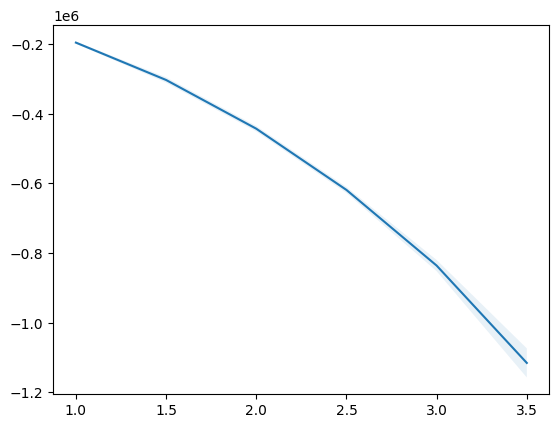

In [112]:
x = [1,1.5,2,2.5,3,3.5,4,4.5,5]

std = results.groupby(['mu']).std()['likelihood']
prec = results.groupby(['mu']).mean()['alpha precision']
kl_div = results.groupby(['mu']).mean()['kl divergence']
likelihood = results.groupby(['mu']).mean()['likelihood']

#plt.plot(x, prec, label = 'alpha precision')
#plt.plot(x, kl_div, label = 'inverse kl div')
plt.plot(x, likelihood, label = 'likelihood')

plt.fill_between(x, likelihood - std, likelihood + std, alpha=0.1)

#fig, ax1 = plt.subplots()

# Plot the first series with the primary y-axis
#ax1.plot(x, prec, label = 'alpha precision')
#ax1.plot(x, kl_div, label = 'inverse kl div')

# Create a second y-axis and plot the second series
#ax2 = ax1.twinx()
#ax2.plot(x, likelihood, label = 'likelihood', c = 'darkgreen')

#ax1.legend()
#ax2.legend()
plt.savefig('plots/covariate_shift_illustrative.png')


#plt.ylim([-0.05,1])

#plt.savefig('plots/covariate_shift_mu.png')

In [140]:
#to show metrics dont penalise complete swapping of treatment populations

alpha = AlphaPrecision()
kl = InverseKLDivergence()
m = 3

X_0 = pd.DataFrame(np.random.normal(loc = m, size=(1000,20)))
X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(1000,20)))
X_0['w'] = 0
X_1['w'] = 1
d = pd.concat([X_0, X_1], axis=0)
d['y'] = np.random.normal(loc = 0, size=(2000,1))


X_0 = pd.DataFrame(np.random.normal(loc = m, size=(1000,20)))
X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(1000,20)))
X_0['w'] = 1
X_1['w'] = 0
d_adv = pd.concat([X_0, X_1], axis=0)
d_adv['y'] = np.random.normal(loc = 0, size=(2000,1))

alpha.evaluate(GenericDataLoader(d), GenericDataLoader(d_adv))

{'delta_precision_alpha_OC': 0.6652666666666667,
 'delta_coverage_beta_OC': 0.18786666666666652,
 'authenticity_OC': 0.77,
 'delta_precision_alpha_naive': 0.9853850574712644,
 'delta_coverage_beta_naive': 0.0,
 'authenticity_naive': 1.0}

In [141]:
kl.evaluate(GenericDataLoader(d), GenericDataLoader(d_adv))

{'marginal': 0.9952790788607224}

In [352]:
covariate_fidelity(d, {'d_adv':d_adv, 'real':d}, 'w', 'y')

,dataset,f0,f1,covariate fidelity
0,d_adv,0.000000,0.000000,0.000000
1,real,0.999336,0.999336,0.999336


##  Subgroup dropping

In [24]:
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

In [25]:
#to show current models consistently drop subgroups
def subgroup_example(n_small, n_iter, save=False):
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()
    results = pd.DataFrame(columns = ['subgroups', 'beta recall', 'kl', 'proportion modelled'])

    for n in n_small:

        vectors_list = [np.repeat(-5*i, 10) for i in range(n+1)]

        def closest_vector(row):
            row = row[[str(i) for i in range(10)]]
            distances = [euclidean_distance(row, vector) for vector in vectors_list]
            closest_index = np.argmin(distances)
            return closest_index
        
        for _ in range(n_iter):
            X_main = pd.DataFrame(np.random.normal(loc = 0, size=(1000,10)))
            X_main['w']=0
            X_main.loc[0:len(X_main)/2-1, 'w']=1

            X_smalls = pd.DataFrame()
            for i in range(n):
                X = pd.DataFrame(np.random.normal(loc = -5*(i+1), size=(10,10)))
                X['w']=0
                X.loc[0:len(X)/2-1, 'w']=1

                X_smalls = pd.concat([X_smalls, X], axis=0)

            d = pd.concat([X_main, X_smalls], axis=0)
            d['y'] = np.random.normal(loc = 0, size=(1000+n*10,1))
            g = Plugins().get('ctgan')
            g.fit(d)
            synth = g.generate(count = 1000 + n*10)
            

            recall = alpha.evaluate(GenericDataLoader(d), synth)['delta_coverage_beta_OC']
            kl_div = kl.evaluate(GenericDataLoader(d), synth)['marginal']

            synth.dataframe()['subgroup'] = synth.dataframe().apply(closest_vector, axis=1)
            subgroups = len(synth.dataframe().groupby('subgroup').count())
            proportion_modelled = subgroups / (n+1)

            results.loc[(len(results))] = [n, recall, kl_div, proportion_modelled]

    if save:
        results.to_csv('subgroup_example_ctgan.csv', index=False)  
    return results

In [86]:
results = subgroup_example([1,2,3,4,5,6,7,8,9,10], 5, save=True)

[2024-04-28T16:51:24.693614+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:51:24.694311+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:51:24.694723+0000][3754226][CRITICAL] module plugin_goggle load failed
 40%|███▉      | 799/2000 [01:21<02:02,  9.77it/s]
[2024-04-28T16:52:50.323335+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:52:50.324083+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:52:50.324539+0000][3754226][CRITICAL] module plugin_goggle load failed
 37%|███▋      | 749/2000 [01:16<02:08,  9.75it/s]
[2024-04-28T16:54:11.007238+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-28T16:54:11.

In [98]:
results = pd.read_csv('subgroup_example_ctgan.csv')

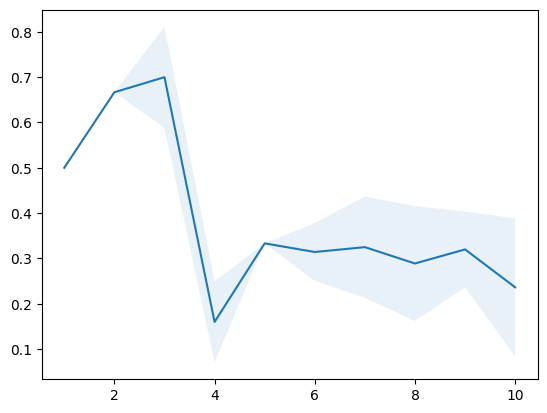

In [110]:
x = [1,2,3,4,5,6,7,8,9,10]
prop = 1- results.groupby('subgroups').mean()['proportion modelled']
std = results.groupby('subgroups').std()['proportion modelled']

plt.plot(prop)
plt.fill_between(x, prop - std, prop + std, alpha=0.1)
plt.savefig('plots/subgroup_illustrative.png')

## Propensity Failure

In [455]:
#to show metric failure for subgroup dropping
n = 10
n_cov = 50
alpha = AlphaPrecision()
kl = InverseKLDivergence()
d = pd.DataFrame(np.random.normal(loc = 0, size=(1000,n_cov)))
d['w']=0
d.loc[0:len(d)/2-1, 'w']=1

d_adv = d.copy()
d_adv['w'] = 1
d_adv.loc[len(d_adv)-1, 'w']=0

d['y']=0
d_adv['y']=0

recall = alpha.evaluate(GenericDataLoader(d), GenericDataLoader(d_adv))['delta_coverage_beta_OC']
kl_div = kl.evaluate(GenericDataLoader(d), GenericDataLoader(d_adv))['marginal']

In [456]:
print(f'recall: {recall}, kl div: {kl_div}')

recall: 0.8202666666666667, kl div: 0.9858821235211305


In [457]:
evaluate_d(d, d_adv, 'w', 'y')

0.5090279352328668

In [460]:
def propensity_degeneration(n_cov, n_iter):
    results = pd.DataFrame(columns=['n_cov', 'avg propensity real', 'avg propensity synth', 'kl', 'beta recall'])
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()

    for n in n_cov:
        for _ in range(n_iter):
            d = pd.DataFrame(np.random.normal(loc = 0, size=(1000,n)))
            d['w']=0
            d.loc[0:len(d)/2-1, 'w']=1
            d['y'] = np.random.normal(loc = 0, size=(1000,1))
            d = d.sample(frac=1)

            g = Plugins().get('ddpm')
            g.fit(d)
            s = g.generate(1000).dataframe()

            d_train = d[:900]
            d_test = d[900:]
            s_train = s[:900]

            pi_real = train_propensity_function(d_train, 'w', 'y')
            probabilities_real = pi_real.predict_proba(np.array(d_test.drop(['w', 'y'], axis=1)))
            propensities_real = probabilities_real[:, 1]
            avg_prop_real = np.mean(propensities_real)

            pi_synth = train_propensity_function(s_train, 'w', 'y')
            probabilities_synth = pi_synth.predict_proba(np.array(d_test.drop(['w', 'y'], axis=1)))
            propensities_synth = probabilities_synth[:, 1]
            avg_prop_synth = np.mean(propensities_synth)


            beta = alpha.evaluate(GenericDataLoader(d), GenericDataLoader(s))['delta_coverage_beta_OC']
            kl_div = kl.evaluate(GenericDataLoader(d), GenericDataLoader(s))['marginal']
            results.loc[(len(results))] = [n, avg_prop_real, avg_prop_synth, kl_div, beta]

    return results

In [461]:
results_ddpm = propensity_degeneration([1,10,20,30,40,50], 3)

[2024-05-01T04:59:22.705805+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-01T04:59:22.706680+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-01T04:59:22.707046+0000][179846][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.92it/s, loss=1.19]
[2024-05-01T04:59:39.341881+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-01T04:59:39.342571+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-01T04:59:39.342952+0000][179846][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.65it/s, loss=1.2]
[2024-05-01T04:59:56.111498+0000][179846][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 

In [464]:
mses_real = [mean_squared_error(results_ddpm[results_ddpm['n_cov']==i]['avg propensity real'], np.repeat(0.5, 3), squared = False) for i in [1,10,20,30,40,50]]
mses_synth = [mean_squared_error(results_ddpm[results_ddpm['n_cov']==i]['avg propensity synth'], np.repeat(0.5, 3), squared = False) for i in [1,10,20,30,40,50]]

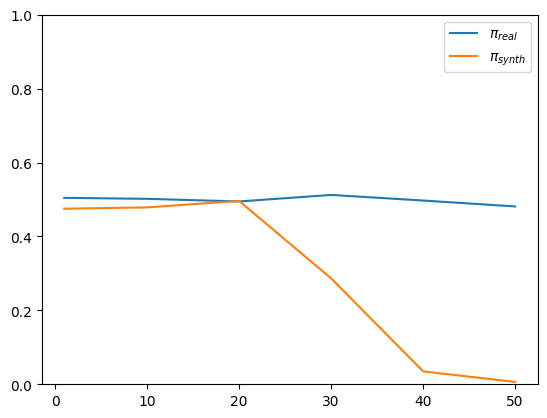

In [463]:
X = [1,10,20,30,40,50]

real_y = results_ddpm.groupby('n_cov').mean()['avg propensity real']
synth_y = results_ddpm.groupby('n_cov').mean()['avg propensity synth']
plt.plot(real_y, label = '$\pi_{real}$')
plt.plot(synth_y, label = '$\pi_{synth}$')
plt.legend()

plt.ylim([0,1])
plt.savefig('plots/propensity_failure.png')

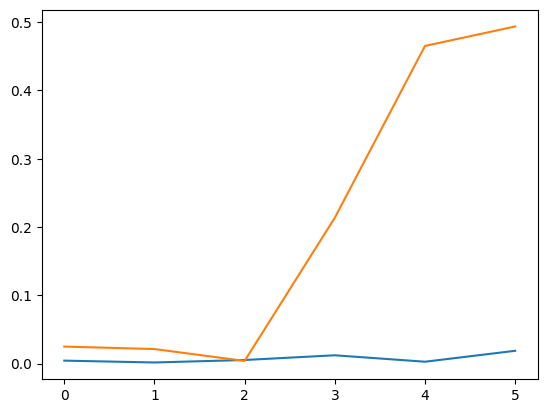

In [465]:
plt.plot(mses_real)
plt.plot(mses_synth)

In [467]:
results_ddpm.to_csv('propensity_failure_ddpm.csv', index=False)

## New generation ideas

### Training a generator for each treatment group

In [406]:
def train_models_separate(gen_list, datasets, n_runs, treatment_cols):
    j=0

    for g in gen_list:
        for d in datasets:
            treatment_col = treatment_cols[j]

            dataset = datasets[d]
            dataset_0 = dataset[dataset[treatment_col] == 0].drop(treatment_col, axis=1)
            dataset_1 = dataset[dataset[treatment_col] == 1].drop(treatment_col, axis=1)

            for i in range(n_runs):

                print(f'Training model {g} iteration {i} on dataset {d} treatment 0')
                model = Plugins().get(g)
                model.fit(dataset_0)
                fp = 'separate_models/' + g + '_' + d + '0_' + str(i) + '.pkl'
                save_to_file(fp, model)

                print(f'Training model {g} iteration {i} on dataset {d} treatment 1')
                model = Plugins().get(g)
                model.fit(dataset_1)
                fp = 'separate_models/' + g + '_' + d + '1_' + str(i) + '.pkl'
                save_to_file(fp, model)
        j += 1

In [419]:
def generate_data_separate(model0, model1, pi, n, treatment_col):
    n_1 = round(n*pi)
    n_0 = n - n_1

    g_0 = load_from_file('separate_models/' + model0)
    g_1 = load_from_file('separate_models/' + model1)
    df_0 = g_0.generate(count = n_0).dataframe()
    df_0[treatment_col] = 0
    df_1 = g_1.generate(count = n_1).dataframe()
    df_1[treatment_col] = 1

    df = pd.concat([df_0, df_1])

    model0 = model0.split('.')[0]
    name_list = model0.split('_')
    name = name_list[0] + '_' + name_list[1][:-1] + '_' + name_list[2]
    df.to_csv('syn_data_separate/' + name + '_separate.csv', index=False)

In [324]:
def gen_sep(real, gen, treatment_col):
    dataset_0 = real[real[treatment_col] == 0].drop(treatment_col, axis=1)
    dataset_1 = real[real[treatment_col] == 1].drop(treatment_col, axis=1)
    n = len(real)
    pi = sum(real[treatment_col]) / n
    n_1 = round(n*pi)
    n_0 = n - n_1
    g_0 = Plugins().get(gen)
    g_0.fit(dataset_0)
    g_1 = Plugins().get(gen)
    g_1.fit(dataset_1)
    df_0 = g_0.generate(count = n_0).dataframe()
    df_0[treatment_col] = 0
    df_1 = g_1.generate(count = n_1).dataframe()
    df_1[treatment_col] = 1
    df = pd.concat([df_0, df_1])

    return df

In [351]:
m = 1

X_0 = pd.DataFrame(np.random.normal(loc = m, size=(2000,20)))
X_1 = pd.DataFrame(np.random.normal(loc = -m, size=(2000,20)))
X_0['w'] = 0
X_1['w'] = 1
d = pd.concat([X_0, X_1], axis=0)
d['y'] = np.random.normal(loc = 0, size=(4000,1))

In [352]:
synth_sep = gen_sep(d, 'ctgan', 'w')

[2024-04-30T07:45:40.868909+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:45:40.869464+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:45:40.869947+0000][4191568][CRITICAL] module plugin_goggle load failed
 42%|████▏     | 849/2000 [02:59<04:03,  4.73it/s]
[2024-04-30T07:48:47.132985+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:48:47.133526+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:48:47.133968+0000][4191568][CRITICAL] module plugin_goggle load failed
 27%|██▋       | 549/2000 [01:54<05:02,  4.79it/s]


In [353]:
synth = generate_standard(d, 'ctgan')

[2024-04-30T07:50:48.657028+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:50:48.658350+0000][4191568][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-30T07:50:48.658777+0000][4191568][CRITICAL] module plugin_goggle load failed
 27%|██▋       | 549/2000 [04:42<12:26,  1.94it/s]


In [356]:
evaluate_d(d, synth_sep, 'w', 'y')

0.002374114615312479

In [357]:
evaluate_d(d, synth, 'w', 'y')

0.014232456084814337

In [427]:
gen_list = ['ddpm']
datasets = {}
datasets['acic'] = acic

In [428]:
train_models_separate(gen_list, datasets, 1, ['z'])

[2024-04-29T04:10:11.992729+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:10:11.993217+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:10:11.993525+0000][3754226][CRITICAL] module plugin_goggle load failed


Training model ddpm iteration 0 on dataset acic treatment 0


Epoch: 100%|██████████| 1000/1000 [01:32<00:00, 10.76it/s, loss=0.876]
[2024-04-29T04:11:45.183756+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:11:45.184238+0000][3754226][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-29T04:11:45.184579+0000][3754226][CRITICAL] module plugin_goggle load failed


Training model ddpm iteration 0 on dataset acic treatment 1


Epoch: 100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s, loss=1.26]


In [426]:
sum(acic['z'])/len(acic)

0.17867555185339443

In [429]:
generate_data_separate('ddpm_acic0_0.pkl', 'ddpm_acic0_0.pkl', 0.179, 747, 'treatment')

In [430]:
separate = pd.read_csv('syn_data_separate/ddpm_acic_0_separate.csv')

In [434]:
separate = separate.rename(columns = {'treatment':'z'})

### Generation in a sequential manner, mimicing the true DGP

Given a real dataset $D = [X, W, Y]$, will train a generative model only on the covariates $X$. Then will predict the treatment assignment $W$ based on the propensity score $\pi(x)$ for each instance, where $\pi(.)$ is learnt from the real dataset. Then, will generate the outcomes $Y$ based on a conditional generative model that has been trained on $D$.

In [29]:
def generate_sequentially(real, gen, treatment_col, outcome_col, encode=False):
    random.seed()

    #generate covariates
    g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    g.fit(real_cov)
    synth_cov = g.generate(count = len(real)).dataframe()

    if encode:
        real_encoded, syn_encoded = encode_acic(real, synth_cov)
    else:
        real_encoded, syn_encoded = real, synth_cov

    #generate propensities
    X = np.array(real_encoded.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real_encoded[treatment_col])
    
    classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    classifier.fit(X, y)
    probabilities = classifier.predict_proba(np.array(syn_encoded))
    prob_class_1 = probabilities[:, 1]
    binary_outcomes = np.random.binomial(n=1, p=prob_class_1)
    synth_cov_with_prop = np.column_stack((binary_outcomes, np.array(synth_cov)))
    synth_cov_with_prop = pd.DataFrame(synth_cov_with_prop, columns=real.drop(outcome_col, axis=1).columns)

    #generate outcome
    g_cond = Plugins().get(gen, random_state = random.randint(0, 1000000))
    g_cond.fit(real, cond = real.drop(outcome_col, axis=1))
    synth_cov_with_prop_and_y = g_cond.generate(count = len(real), cond = synth_cov_with_prop)
    
    return synth_cov_with_prop_and_y.dataframe()

In [30]:
def generate_sequentially_to_w(real, gen, treatment_col, outcome_col, encode=False):
    random.seed()

    #generate covariates
    g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    real_cov = real.drop([treatment_col, outcome_col], axis=1)
    g.fit(real_cov)
    synth_cov = g.generate(count = len(real)).dataframe()

    if encode:
        real_encoded, syn_encoded = encode_acic(real, synth_cov)
    else:
        real_encoded, syn_encoded = real, synth_cov

    #generate propensities
    X = np.array(real_encoded.drop([treatment_col, outcome_col], axis=1))
    y = np.array(real_encoded[treatment_col])
    
    classifier = LogisticRegression(random_state = random.randint(0, 1000000))
    classifier.fit(X, y)
    probabilities = classifier.predict_proba(np.array(syn_encoded))
    prob_class_1 = probabilities[:, 1]
    binary_outcomes = np.random.binomial(n=1, p=prob_class_1)

    synth_cov_with_prop = syn_encoded
    synth_cov_with_prop[treatment_col] = pd.Series(binary_outcomes)

    #synth_cov_with_prop = np.column_stack((binary_outcomes, np.array(synth_cov)))
    #synth_cov_with_prop = pd.DataFrame(synth_cov_with_prop, columns=real.drop(outcome_col, axis=1).columns)
    synth_cov_with_prop[outcome_col] = 0

    return synth_cov_with_prop

In [31]:
def generate_standard(real, gen):
    random.seed()
    g = Plugins().get(gen, random_state = random.randint(0, 1000000))
    g.fit(real)
    synth = g.generate(count = len(real)).dataframe()
    return synth

In [32]:
def sequential_exp(real, gens, treatment_col, outcome_col, n_iter, encode = False, save=False, fp=''):
    results = pd.DataFrame(columns = ['type', 'gen', 'alpha precision', 'beta recall', 'kl', 'f', 'd', 'u_pehe', 'u_policy', 'u_int'])

    for gen in gens:
        for _ in range(n_iter):
            alpha = AlphaPrecision(random_state = random.randint(0, 1000000))
            kl = InverseKLDivergence(random_state = random.randint(0, 1000000))
            #train and evaluate normal synth gen
            synth = generate_standard(real, gen)
        
            if encode:
                real_encoded, synth_encoded = encode_acic(real, synth)
            else:
                real_encoded = real
                synth_encoded = synth

            n_units = len(real_encoded.drop([treatment_col, outcome_col], axis=1).columns)
            standard_f = evaluate_f(real_encoded, synth_encoded, treatment_col, outcome_col)
            standard_d = evaluate_d(real_encoded, synth_encoded, treatment_col, outcome_col)
            standard_u_pehe = evaluate_u_pehe(real_encoded, synth_encoded, treatment_col, outcome_col, n_units)
            standard_u_policy = evaluate_u_policy(real_encoded, synth_encoded, treatment_col, outcome_col, n_units)
            standard_u_int = evaluate_u_int(real_encoded, synth_encoded, treatment_col, outcome_col, n_units)[0]
            standard_alpha = alpha.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_encoded))['delta_precision_alpha_OC']
            standard_beta = alpha.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_encoded))['delta_coverage_beta_OC']
            standard_kl = kl.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_encoded))['marginal']
            results.loc[(len(results))] = ['standard', gen, standard_alpha, standard_beta, standard_kl, standard_f, standard_d, standard_u_pehe, standard_u_policy, standard_u_int]

            #train and evaluate sequential synth gen

            synth_sequential = generate_sequentially(real, gen, treatment_col, outcome_col, encode=encode)

            if encode:
                real_encoded, synth_sequential_encoded = encode_acic(real, synth_sequential)
            else:
                real_encoded = real
                synth_sequential_encoded = synth_sequential
            
            sequential_f = evaluate_f(real_encoded, synth_sequential_encoded, treatment_col, outcome_col)
            sequential_d = evaluate_d(real_encoded, synth_sequential_encoded, treatment_col, outcome_col)
            sequential_u_pehe = evaluate_u_pehe(real_encoded, synth_sequential_encoded, treatment_col, outcome_col, n_units)
            sequential_u_policy = evaluate_u_policy(real_encoded, synth_sequential_encoded, treatment_col, outcome_col, n_units)
            sequential_u_int = evaluate_u_int(real_encoded, synth_sequential_encoded, treatment_col, outcome_col, n_units)[0]
            sequential_alpha = alpha.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_sequential_encoded))['delta_precision_alpha_OC']
            sequential_beta = alpha.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_sequential_encoded))['delta_coverage_beta_OC']
            sequential_kl = kl.evaluate(GenericDataLoader(real_encoded), GenericDataLoader(synth_sequential_encoded))['marginal']
            results.loc[(len(results))] = ['sequential', gen, sequential_alpha, sequential_beta, sequential_kl, sequential_f, sequential_d, sequential_u_pehe, sequential_u_policy, sequential_u_int]

    if save:
        results.to_csv(fp, index=False)

    return results

In [247]:
#results_acic = sequential_exp(acic, ['ctgan', 'tvae'], 'z', 'y', 10, encode=True, save=True, fp='sequential_acic.csv')

[2024-05-02T12:20:36.756592+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:20:36.757720+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:20:36.758635+0000][845410][CRITICAL] module plugin_goggle load failed
 30%|██▉       | 599/2000 [11:09<26:04,  1.12s/it]  
[2024-05-02T12:33:33.850881+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:33:33.851809+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:33:33.852286+0000][845410][CRITICAL] module plugin_goggle load failed
 45%|████▍     | 899/2000 [16:32<20:15,  1.10s/it]  
[2024-05-02T12:50:17.162960+0000][845410][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-02T12:50:17.163

In [251]:
results_acic.groupby(['gen','type']).mean()

alpha precision  beta recall        kl         f         d  \
gen   type                                                                     
ctgan sequential         0.630107     0.263368  0.913187  0.608268  0.828427   
      standard           0.791483     0.397350  0.962707  0.771165  0.921332   
tvae  sequential         0.746958     0.149167  0.757034  0.235525  0.795396   
      standard           0.854826     0.488517  0.921938  0.867569  0.914845   

                    u_pehe  u_policy     u_int  
gen   type                                      
ctgan sequential  5.785403  0.425625 -0.183588  
      standard    5.320378  0.594271  0.097978  
tvae  sequential  4.882178  0.899271 -0.151630  
      standard    4.791150  0.657500 -0.020242

In [32]:
results = pd.read_csv('sequential_results.csv')

In [33]:
results.groupby(['gen', 'type']).std()

alpha precision  beta recall        kl         f         d  \
gen   type                                                                     
ctgan sequential         0.033037     0.021172  0.008357  0.034892  0.016167   
      standard           0.036844     0.032456  0.014393  0.043812  0.023874   
tvae  sequential         0.000000     0.000000  0.000000  0.000000  0.000000   
      standard           0.000000     0.000000  0.000000  0.000000  0.000000   

                    u_pehe  u_policy     u_int  
gen   type                                      
ctgan sequential  0.413258  0.063591  0.238126  
      standard    0.333809  0.061596  0.186170  
tvae  sequential  0.000000  0.000000  0.000000  
      standard    0.000000  0.000000  0.000000

In [35]:
results.groupby(['gen', 'type']).mean()

alpha precision  beta recall        kl         f         d  \
gen   type                                                                     
ctgan sequential         0.720286     0.414663  0.913332  0.268681  0.089418   
      standard           0.670799     0.414743  0.952885  0.252751  0.140448   
tvae  sequential         0.851406     0.404641  0.820582  0.298433  0.178706   
      standard           0.795984     0.427577  0.894903  0.192371  0.111379   

                    u_pehe  u_policy     u_int  
gen   type                                      
ctgan sequential  2.637129  0.838926  0.153424  
      standard    2.834454  0.783221  0.117513  
tvae  sequential  2.311922  0.885906  0.270680  
      standard    3.378427  0.704698 -0.058206

In [51]:
jobs_cov = jobs.drop(['training', 're78'], axis=1)

In [112]:
stand = generate_standard(jobs, 'ddpm')

[2024-05-03T00:00:06.000533+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T00:00:06.001492+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T00:00:06.002251+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 78.62it/s, loss=0.932]


In [113]:
synth_cov = generate_standard(jobs_cov, 'ddpm')

X = np.array(jobs.drop(['training', 're78'], axis=1))
y = np.array(jobs['training'])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = LogisticRegression(random_state = random.randint(0, 1000000))
classifier.fit(X, y)
probabilities = classifier.predict_proba(np.array(synth_cov))
prob_class_1 = probabilities[:, 1]
binary_outcomes = np.random.binomial(n=1, p=prob_class_1)
synth_cov_with_prop = np.column_stack((binary_outcomes, np.array(synth_cov)))
synth_cov_with_prop = pd.DataFrame(synth_cov_with_prop, columns=jobs.drop('re78', axis=1).columns)

#generate outcome
#g_cond = Plugins().get(gen, random_state = random.randint(0, 1000000))
#g_cond.fit(real, cond = real.drop(outcome_col, axis=1))
#synth_cov_with_prop_and_y = g_cond.generate(count = len(real), cond = synth_cov_with_prop)

[2024-05-03T00:00:24.136722+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T00:00:24.137978+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T00:00:24.138444+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 81.29it/s, loss=0.789]


In [33]:
def seq_test(real, gen, treatment_col, outcome_col, n_iter, encode=False):
    results = pd.DataFrame(columns = ['method', 'f', 'd', 'u_pehe', 'u_policy', 'u_int'])
    for _ in range(n_iter):
        stand = generate_standard(real, gen)
        seq_new = generate_sequentially_to_w(real, gen, treatment_col, outcome_col, encode=encode)

        #gen Y sequentially
        n_units = len(real.drop([treatment_col, outcome_col], axis=1).columns)
        l = TLearner(n_unit_in=n_units, binary_y=False, seed=random.randint(0,1000000))
        X = np.array(real.drop([treatment_col, outcome_col], axis=1))
        y = np.array(real[outcome_col])
        w = np.array(real[treatment_col])
        l.fit(X, y, w)

        seq_X = np.array(seq_new.drop([treatment_col, outcome_col], axis=1))
        cate, y0, y1 = l.predict(seq_X, return_po=True)

        outcomes = []
        for index, value in seq_new[treatment_col].iteritems():
            if value == 0:
                outcomes.append(y0[index].item())
            else:
                outcomes.append(y1[index].item())

        seq_new[outcome_col] = outcomes

        if encode:
            real_encoded, stand_encoded = encode_acic(real, stand)
            _, seq_encoded = encode_acic(real, seq_new)
        else:
            real_encoded = real
            stand_encoded = stand
            seq_encoded = seq_new

        results.loc[len(results)] = ['standard', evaluate_f(real_encoded, stand_encoded, treatment_col, outcome_col), evaluate_d(real_encoded, stand_encoded, treatment_col, outcome_col),
                                     evaluate_u_pehe(real_encoded, stand_encoded, treatment_col, outcome_col, n_units), evaluate_u_policy(real_encoded, stand_encoded, treatment_col, outcome_col, n_units),
                                     evaluate_u_int(real_encoded, stand_encoded, treatment_col, outcome_col, n_units)[0]]
        results.loc[len(results)] = ['seq_new', evaluate_f(real_encoded, seq_encoded, treatment_col, outcome_col), evaluate_d(real_encoded, seq_encoded, treatment_col, outcome_col),
                                     evaluate_u_pehe(real_encoded, seq_encoded, treatment_col, outcome_col, n_units), evaluate_u_policy(real_encoded, seq_encoded, treatment_col, outcome_col, n_units),
                                     evaluate_u_int(real_encoded, seq_encoded, treatment_col, outcome_col, n_units)[0]]
    return results


In [53]:
results_ihdp = seq_test(ihdp, 'tvae', 'treatment', 'y_factual', 5)

[2024-05-04T04:51:55.397342+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T04:51:55.398873+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T04:51:55.399538+0000][1467476][CRITICAL] module plugin_goggle load failed
 50%|█████     | 500/1000 [00:45<00:45, 11.04it/s]
[2024-05-04T04:52:41.848751+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T04:52:41.849415+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T04:52:41.849865+0000][1467476][CRITICAL] module plugin_goggle load failed
 45%|████▌     | 450/1000 [00:33<00:40, 13.45it/s]
[2024-05-04T04:54:24.068183+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T04:54:24.

In [54]:
results_ihdp.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.286917,0.899613,2.456735,0.864430,0.182213
standard,0.204013,0.843429,4.345521,0.406711,-0.125151


In [55]:
results_ihdp.groupby('method').std()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.036222,0.005767,0.109587,0.011028,0.097999
standard,0.064302,0.047463,0.772279,0.131139,0.190848


In [52]:
results_ihdp

,method,f,d,u_pehe,u_policy,u_int
0,standard,0.107091,0.797313,4.093799,0.516779,0.089731
1,seq_new,0.216606,0.855548,2.700191,0.805369,0.180426
2,standard,0.132199,0.856549,3.805563,0.651007,0.285313
3,seq_new,0.232652,0.914326,2.620540,0.892617,0.180848
4,standard,0.129485,0.840431,3.360182,0.885906,0.203127
5,seq_new,0.122332,0.888483,3.390398,0.751678,0.497498
6,standard,0.147035,0.861420,4.134737,0.838926,0.024080
7,seq_new,0.200487,0.900544,2.311017,0.906040,0.534696
8,standard,0.173225,0.812917,3.706123,0.818792,0.002257
9,seq_new,0.231636,0.913793,2.507770,0.892617,0.455117


In [56]:
results_ihdp.to_csv('ihdp_sequential_vs_standard_tvae.csv', index=False)

In [57]:
results_jobs = seq_test(jobs, 'tvae', 'training', 're78', 5)

[2024-05-04T05:04:31.328160+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T05:04:31.329704+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T05:04:31.330244+0000][1467476][CRITICAL] module plugin_goggle load failed
 60%|██████    | 600/1000 [00:21<00:14, 27.49it/s]
[2024-05-04T05:04:53.971828+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T05:04:53.972473+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T05:04:53.972859+0000][1467476][CRITICAL] module plugin_goggle load failed
 45%|████▌     | 450/1000 [00:14<00:18, 30.06it/s]
[2024-05-04T05:05:42.374895+0000][1467476][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-04T05:05:42.

In [58]:
results_jobs.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.765332,0.886327,1.924728,0.931944,0.308303
standard,0.809499,0.858502,5.755601,0.583333,0.649562


In [59]:
results_jobs.groupby('method').std()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.048353,0.019929,0.528809,0.035883,0.323667
standard,0.071531,0.029812,1.380149,0.355560,0.227628


In [60]:
results_jobs.to_csv('jobs_sequential_vs_standard_tvae.csv', index=False)

### Insights

How does altering the size of $D_\text{real}$ affect the performance difference between standard and sequential generation?

In [273]:
X,y,w,p,t = simulate_treatment_setup(200, d=10, n_o=5, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [274]:
test_small = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:31:39.097615+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:39.098649+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:39.099041+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.36it/s, loss=0.989]
[2024-05-03T02:31:50.969285+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:50.969945+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:31:50.970408+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:04<00:00, 217.33it/s, loss=0.386]
[2024-05-03T02:33:20.888257+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has n

In [275]:
test_small.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.015315,0.770233,4.121382,0.691667,0.719221
standard,0.002097,0.716804,9.071507,0.666667,0.316862


In [271]:
test.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.360417,0.88249,2.100155,0.93,0.927594
standard,0.152567,0.82901,7.167894,0.94,-0.003107


In [272]:
test

,method,f,d,u_pehe,u_policy,u_int
0,standard,0.167027,0.867223,6.095212,0.955,0.072566
1,seq_new,0.439605,0.887411,2.238435,0.940,0.902416
2,standard,0.147813,0.832681,7.002279,0.890,0.150050
3,seq_new,0.333976,0.890791,1.966447,0.920,0.959688
4,standard,0.142860,0.787125,8.406189,0.975,-0.231937
5,seq_new,0.307669,0.869267,2.095585,0.930,0.920677


How does altering the complexity of $\pi$, aka the number of confounding, change the performance delta

In [292]:
X,y,w,p,t = simulate_treatment_setup(500, d=10, n_c=0, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [293]:
test_no_conf = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:41:49.165677+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:41:49.167369+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:41:49.167746+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 106.30it/s, loss=0.874]
[2024-05-03T02:42:02.367143+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:42:02.367865+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:42:02.368231+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:05<00:00, 172.63it/s, loss=0.445]
[2024-05-03T02:43:03.426300+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has n

In [294]:
test_no_conf.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.129772,0.821495,1.642043,0.756667,0.945134
standard,0.040088,0.820911,5.189636,0.716667,0.621149


In [295]:
X,y,w,p,t = simulate_treatment_setup(500, d=10, n_c=5, n_t=5)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [296]:
test_conf = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:45:15.541286+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:15.541946+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:15.542539+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 102.82it/s, loss=0.94]
[2024-05-03T02:45:28.928814+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:28.929577+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:45:28.930003+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:05<00:00, 172.85it/s, loss=0.445]
[2024-05-03T02:47:16.612714+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

In [308]:
test_conf

,method,f,d,u_pehe,u_policy,u_int
0,standard,0.022478,0.703656,14.005186,0.87,0.617082
1,seq_new,0.113149,0.893558,2.330140,1.00,0.882679
2,standard,0.026847,0.738174,14.396672,0.97,0.608709
3,seq_new,0.106421,0.896517,2.045986,0.98,0.944349
4,standard,0.023043,0.786037,9.014050,0.98,0.424975
5,seq_new,0.076220,0.886541,2.258104,0.99,0.950160


In [318]:
def confounding_insight(n, d, n_t, n_cs, gen, n_iter, save=False, fp=''):
    results = pd.DataFrame(columns=['method', 'f', 'd', 'u_pehe', 'u_policy', 'u_int', 'n_c'])
    for n_c in n_cs:
        X,y,w,p,t = simulate_treatment_setup(n, d=d, n_c=n_c, n_t=n_t)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])
        d_real = pd.concat([X_df,w_df,y_df], axis=1)

        r = seq_test(d_real, gen, 'w', 'y', n_iter)
        r['n_c'] = n_c
        results = pd.concat([results, r])
        print(f'Tested n_c = {n_c}')

    if save:
        results.to_csv(fp, index=False)
        
    return results

In [320]:
conf_results = confounding_insight(1000, 10, 5, [0,1,2,3,4,5], 'ddpm', 3, save=True, fp = 'confounding_insight.csv')

[2024-05-03T03:21:08.625706+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:21:08.626341+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:21:08.626710+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.02it/s, loss=0.886]
[2024-05-03T03:21:24.600742+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:21:24.601441+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:21:24.602034+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 111.91it/s, loss=0.474]
[2024-05-03T03:22:42.009849+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

Tested n_c = 0


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.27it/s, loss=0.848]
[2024-05-03T03:26:10.222285+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:26:10.222880+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:26:10.223219+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.28it/s, loss=0.471]
[2024-05-03T03:27:39.013447+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:27:39.015102+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:27:39.015516+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.25it/s, loss=0.854]
[2024-05-03T03:27:54.359198+0000][1207925][CRITICA

Tested n_c = 1


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.40it/s, loss=0.879]
[2024-05-03T03:31:22.313827+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:31:22.315182+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:31:22.315779+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 115.22it/s, loss=0.475]
[2024-05-03T03:33:06.261368+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:33:06.262636+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:33:06.263233+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s, loss=0.879]
[2024-05-03T03:33:21.970422+0000][1207925][CRITICA

Tested n_c = 2


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.77it/s, loss=0.883]
[2024-05-03T03:37:18.544428+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:37:18.545353+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:37:18.545699+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 116.22it/s, loss=0.473]
[2024-05-03T03:39:09.347245+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:39:09.348488+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:39:09.349051+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.01it/s, loss=0.889]
[2024-05-03T03:39:24.689028+0000][1207925][CRITICA

Tested n_c = 3


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 80.06it/s, loss=0.913]
[2024-05-03T03:43:29.037418+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:43:29.038192+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:43:29.038648+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 117.95it/s, loss=0.472]
[2024-05-03T03:45:32.732536+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:45:32.733984+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:45:32.734468+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.08it/s, loss=0.913]
[2024-05-03T03:45:48.212196+0000][1207925][CRITICA

Tested n_c = 4


Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.03it/s, loss=0.932]
[2024-05-03T03:50:22.962872+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:50:22.963640+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:50:22.964101+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.22it/s, loss=0.473]
[2024-05-03T03:52:35.908312+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:52:35.909531+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:52:35.909894+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.32it/s, loss=0.928]
[2024-05-03T03:52:51.220470+0000][1207925][CRITICA

Tested n_c = 5


In [327]:
conf_results.groupby(['n_c', 'method']).mean()

f         d     u_pehe  u_policy     u_int
n_c method                                                     
0   seq_new   0.341636  0.889746   1.325231  0.981667  0.975310
    standard  0.222931  0.905049   4.287434  0.958333  0.820297
1   seq_new   0.316715  0.927999   1.326499  0.986667  0.958534
    standard  0.167641  0.879662   5.378494  0.986667  0.790864
2   seq_new   0.345091  0.956996   1.355714  0.991667  0.962309
    standard  0.132041  0.864086   9.084347  0.990000  0.698078
3   seq_new   0.370681  0.900862   1.564026  0.980000  0.968483
    standard  0.096830  0.797705  10.219024  0.998333  0.625311
4   seq_new   0.332848  0.911118   1.757195  0.995000  0.943538
    standard  0.118343  0.824073   9.984284  1.000000  0.789123
5   seq_new   0.306032  0.929061   1.607046  0.998333  0.950747
    standard  0.096011  0.842124   9.179149  0.996667  0.480078

In [42]:
conf_results = pd.read_csv('confounding_insight.csv')

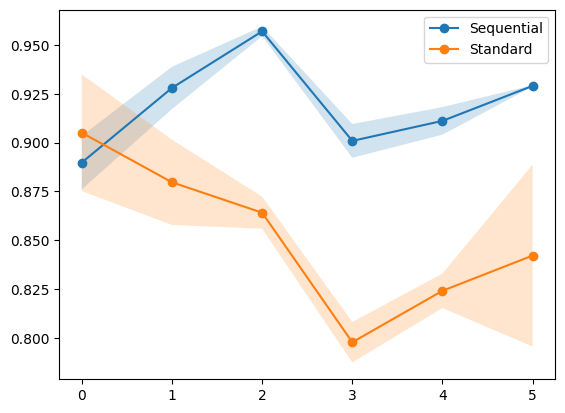

In [46]:
x = [0,1,2,3,4,5]
d_seq = conf_results[conf_results['method']=='seq_new'].groupby(['n_c']).mean()['d']
d_stand = conf_results[conf_results['method']=='standard'].groupby(['n_c']).mean()['d']

d_seq_std = conf_results[conf_results['method']=='seq_new'].groupby(['n_c']).std()['d']
d_stand_std = conf_results[conf_results['method']=='standard'].groupby(['n_c']).std()['d']

plt.plot(x, d_seq, 'o-', label = 'Sequential')
plt.plot(x, d_stand, 'o-', label = 'Standard')

plt.fill_between(x, d_seq - d_seq_std, d_seq + d_seq_std, alpha=0.2)
plt.fill_between(x, d_stand - d_stand_std, d_stand + d_stand_std, alpha=0.2)
plt.legend()
plt.savefig('plots/confounding_complexity_plot.png')

What happens are num covariates increases?

In [300]:
X,y,w,p,t = simulate_treatment_setup(500, d=2, n_o=1, n_t=1)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [301]:
test_cov_small = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T02:56:02.472509+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:02.473777+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:02.474460+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 105.83it/s, loss=1.08]
[2024-05-03T02:56:15.610555+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:15.611305+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T02:56:15.611758+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:06<00:00, 165.80it/s, loss=0.471]
[2024-05-03T02:56:52.424485+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no

In [302]:
test_cov_small.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.949355,0.948425,0.613462,0.756667,0.963520
standard,0.830259,0.914691,1.155762,0.506667,0.999829


What happens as number of predictive variables changes?

In [304]:
X,y,w,p,t = simulate_treatment_setup(1000, d=10, n_o=5, n_t=0)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)

In [306]:
test_predictive_small = seq_test(d_real, 'ddpm', 'w', 'y', 3)

[2024-05-03T03:00:09.996651+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:00:09.997986+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:00:09.998398+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.46it/s, loss=1.18]
[2024-05-03T03:00:25.156620+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:00:25.157282+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:00:25.157715+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 118.25it/s, loss=0.473]
[2024-05-03T03:02:17.626312+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no 

In [307]:
test_predictive_small.groupby('method').mean()

,f,d,u_pehe,u_policy,u_int
method,,,,,
seq_new,0.364447,0.874218,1.522682,0.650000,0.281764
standard,0.241048,0.873644,3.957088,0.541667,0.163142


In [321]:
def predictive_insight(n, d, n_o, n_ts, gen, n_iter, save=False, fp=''):
    results = pd.DataFrame(columns=['method', 'f', 'd', 'u_pehe', 'u_policy', 'u_int', 'n_t'])
    for n_t in n_ts:
        X,y,w,p,t = simulate_treatment_setup(n, d=d, n_o=n_o, n_t=n_t)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])
        d_real = pd.concat([X_df,w_df,y_df], axis=1)

        r = seq_test(d_real, gen, 'w', 'y', n_iter)
        r['n_t'] = n_t
        results = pd.concat([results, r])

        print(f'Tested n_t = {n_t}')

    if save:
        results.to_csv(fp, index=False)
        
    return results

In [322]:
pred_results = predictive_insight(1000, 10, 5, [0,1,2,3,4,5], 'ddpm', 3, save=True, fp = 'predictive_insight.csv')

[2024-05-03T03:57:28.599377+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:57:28.599881+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:57:28.600228+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.82it/s, loss=1.19]
[2024-05-03T03:57:44.100650+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:57:44.101312+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T03:57:44.101735+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 123.65it/s, loss=0.473]
[2024-05-03T03:59:30.925635+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no 

Tested n_t = 0


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.84it/s, loss=1.15]
[2024-05-03T04:04:04.223481+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:04:04.224145+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:04:04.224991+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 122.49it/s, loss=0.473]
[2024-05-03T04:06:01.831237+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:06:01.832325+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:06:01.832731+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 87.34it/s, loss=1.15]
[2024-05-03T04:06:16.949098+0000][1207925][CRITICAL]

Tested n_t = 1


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.28it/s, loss=1.15]
[2024-05-03T04:10:49.133681+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:10:49.134477+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:10:49.134854+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.99it/s, loss=0.472]
[2024-05-03T04:12:52.327887+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:12:52.329111+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:12:52.329490+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.01it/s, loss=1.13]
[2024-05-03T04:13:08.205972+0000][1207925][CRITICAL]

Tested n_t = 2


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.50it/s, loss=1.08]
[2024-05-03T04:17:51.081650+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:17:51.082424+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:17:51.082845+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 121.06it/s, loss=0.472]
[2024-05-03T04:20:05.609952+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:20:05.611296+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:20:05.612018+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 85.79it/s, loss=1.08]
[2024-05-03T04:20:20.987922+0000][1207925][CRITICAL]

Tested n_t = 3


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 84.19it/s, loss=1.04]
[2024-05-03T04:25:16.420199+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:25:16.421140+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:25:16.421654+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.56it/s, loss=0.473]
[2024-05-03T04:27:37.752072+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:27:37.753316+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:27:37.753719+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.94it/s, loss=1.03]
[2024-05-03T04:27:52.967237+0000][1207925][CRITICAL]

Tested n_t = 4


Epoch: 100%|██████████| 1000/1000 [00:11<00:00, 86.20it/s, loss=1]   
[2024-05-03T04:32:50.355121+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:32:50.356279+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:32:50.356718+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:08<00:00, 120.67it/s, loss=0.473]
[2024-05-03T04:35:10.455400+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:35:10.456746+0000][1207925][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-05-03T04:35:10.457125+0000][1207925][CRITICAL] module plugin_goggle load failed
Epoch: 100%|██████████| 1000/1000 [00:12<00:00, 82.63it/s, loss=0.999]
[2024-05-03T04:35:26.276246+0000][1207925][CRITICAL

Tested n_t = 5


In [337]:
pred_results.groupby(['n_t', 'method']).mean()

f         d    u_pehe  u_policy     u_int
n_t method                                                    
0   seq_new   0.333096  0.884656  1.593909  0.608333 -0.013843
    standard  0.256751  0.920536  4.017940  0.501667 -0.032072
1   seq_new   0.351340  0.921066  1.706671  0.631667  0.740538
    standard  0.157086  0.834764  6.425636  0.675000  0.303378
2   seq_new   0.412954  0.898263  1.601148  0.843333  0.812969
    standard  0.205575  0.841318  5.076740  0.591667  0.094904
3   seq_new   0.358265  0.910412  1.913298  0.881667  0.833083
    standard  0.127516  0.793221  7.083297  0.826667  0.222386
4   seq_new   0.341015  0.916567  1.670461  0.938333  0.891404
    standard  0.192416  0.829199  6.363515  0.913333  0.376161
5   seq_new   0.340555  0.884715  2.089306  0.946667  0.916576
    standard  0.134504  0.779132  8.656886  0.946667  0.364400

In [130]:
pred_results = pd.read_csv('predictive_insight.csv')

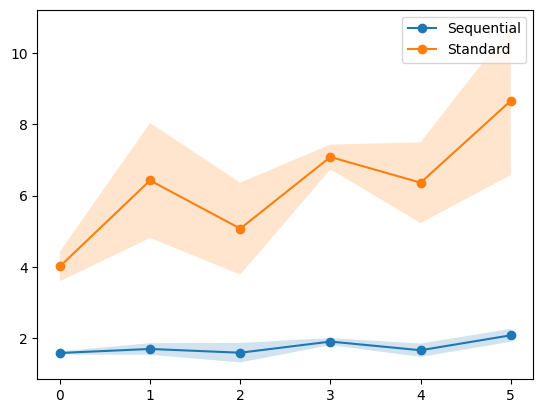

In [131]:

x = [0,1,2,3,4,5]
u_seq = pred_results[pred_results['method']=='seq_new'].groupby(['n_t']).mean()['u_pehe']
u_stand = pred_results[pred_results['method']=='standard'].groupby(['n_t']).mean()['u_pehe']

u_seq_std = pred_results[pred_results['method']=='seq_new'].groupby(['n_t']).std()['u_pehe']
u_stand_std = pred_results[pred_results['method']=='standard'].groupby(['n_t']).std()['u_pehe']

plt.plot(x, u_seq, 'o-', label = 'Sequential')
plt.plot(x, u_stand, 'o-', label = 'Standard')

plt.fill_between(x, u_seq - u_seq_std, u_seq + u_seq_std, alpha=0.2)
plt.fill_between(x, u_stand - u_stand_std, u_stand + u_stand_std, alpha=0.2)
plt.legend()
#plt.savefig('plots/CATE_complexity_plot.png')

## Showing our metrics work

### F

In [194]:
def generate_covariate_shift_datasets(n, mu, correct):
    X_0 = pd.DataFrame(np.random.normal(loc = mu, size=(n,20)))
    X_1 = pd.DataFrame(np.random.normal(loc = -mu, size=(n,20)))
    X_0['w'] = 0
    X_1['w'] = 1
    d = pd.concat([X_0, X_1], axis=0).reset_index(drop=True)
    d['y'] = np.random.normal(loc = 0, size=(2*n,1))

    n_correct = round(correct*n)
    X_0_adv = pd.DataFrame(np.random.normal(loc = mu, size=(n,20)))
    X_0_adv['w'] = 1
    X_0_adv.loc[:n_correct, 'w']=0

    X_1_adv = pd.DataFrame(np.random.normal(loc = -mu, size=(n,20)))
    X_1_adv['w'] = 0
    X_1_adv.loc[:n_correct, 'w']=1

    d_adv = pd.concat([X_0_adv, X_1_adv], axis=0).reset_index(drop=True)
    d_adv['y'] = np.random.normal(loc = 0, size=(2*n,1))

    return d, d_adv

In [229]:
def new_metrics_covariate_shift_exp(n, mu, corrects, n_iter):
    results = pd.DataFrame(columns=['correct %', 'f', 'd', 'alpha', 'kl'])
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()

    for c in corrects:
        for _ in range(n_iter):
            d_real, d_adv = generate_covariate_shift_datasets(n, mu, c)
            f = evaluate_f(d_real,d_adv,'w','y')
            d = evaluate_d(d_real,d_adv,'w','y')
            prec = alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['delta_precision_alpha_OC']
            inv_kl = kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['marginal']
            results.loc[len(results)] = [c, f, d, prec, inv_kl]
            print('done')
    return results


In [230]:
results = new_metrics_covariate_shift_exp(1000, 4, [0,0.2,0.4,0.6,0.8,1], n_iter = 3)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [234]:
results.groupby('correct %').mean()

,f,d,alpha,kl
correct %,,,,
0.0,0.000656,9.989771e-01,0.749389,0.995414
0.2,0.197233,7.987756e-01,0.885088,0.994441
0.4,0.403556,6.004688e-01,0.672864,0.993013
0.6,0.600189,4.030066e-01,0.904268,0.995010
0.8,0.775722,2.026310e-01,0.895829,0.994491
1.0,0.978070,3.676999e-07,0.984003,0.995929


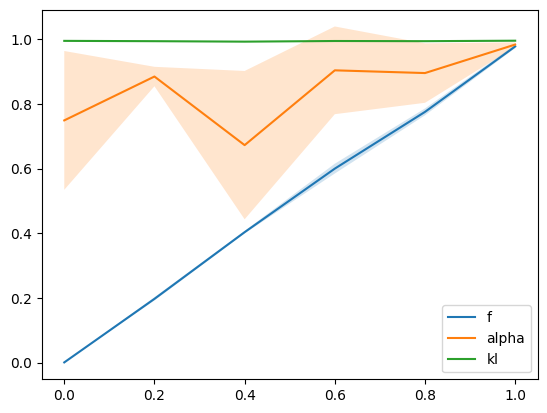

In [239]:
x = [0,0.2,0.4,0.6,0.8,1]
f = results.groupby('correct %').mean()['f']
alpha = results.groupby('correct %').mean()['alpha']
kl = results.groupby('correct %').mean()['kl']
f_std = results.groupby('correct %').std()['f']
alpha_std = results.groupby('correct %').std()['alpha']
kl_std = results.groupby('correct %').std()['kl']

plt.plot(x, f, label = 'f')
plt.plot(x, alpha, label = 'alpha')
plt.plot(x, kl, label = 'kl')

plt.fill_between(x, f - f_std, f + f_std, alpha=0.2)
plt.fill_between(x, alpha - alpha_std, alpha + alpha_std, alpha=0.2)
plt.fill_between(x, kl - kl_std, kl + kl_std, alpha=0.2)
plt.legend()
plt.show()

### D

In [68]:
def generate_propensities_datasets(n, correct):
    d = pd.DataFrame(np.random.normal(loc = 0, size=(n,20)))
    d['w'] = 0
    d.loc[:round(n/2),'w'] = 1
    d['y'] = np.random.normal(loc = 0, size=(n,1))
    d = d.sample(frac=1)

    n_correct = round(correct*n)
    d_adv = pd.DataFrame(np.random.normal(loc = 0, size=(n,20)))
    d_adv['w'] = 0
    d_adv.loc[:n_correct,'w'] = 1
    d_adv['y'] = np.random.normal(loc = 0, size=(n,1))
    d_adv = d_adv.sample(frac=1)

    return d, d_adv

In [71]:
def new_metrics_propensity_exp(n, corrects, n_iter):
    results = pd.DataFrame(columns=['treated %', 'f', 'd', 'beta', 'kl'])
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()

    for c in corrects:
        for _ in range(n_iter):
            d_real, d_adv = generate_propensities_datasets(n, c)
            #f = evaluate_f(d_real,d_adv,'w','y')
            d = evaluate_d(d_real,d_adv,'w','y')
            #prec = alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['delta_coverage_beta_OC']
            #inv_kl = kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_adv))['marginal']
            results.loc[len(results)] = [c, 0, d, 0, 0]
            print('done')
    return results


In [83]:
results_prop = new_metrics_propensity_exp(2000, [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], 100)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [73]:
results_prop

,treated %,f,d,beta,kl
0,0.1,0.0,0.272770,0.0,0.0
1,0.1,0.0,0.259794,0.0,0.0
2,0.1,0.0,0.294363,0.0,0.0
3,0.2,0.0,0.413203,0.0,0.0
4,0.2,0.0,0.427884,0.0,0.0
5,0.2,0.0,0.445803,0.0,0.0
6,0.3,0.0,0.625882,0.0,0.0
7,0.3,0.0,0.610696,0.0,0.0
8,0.3,0.0,0.599282,0.0,0.0
9,0.4,0.0,0.766497,0.0,0.0


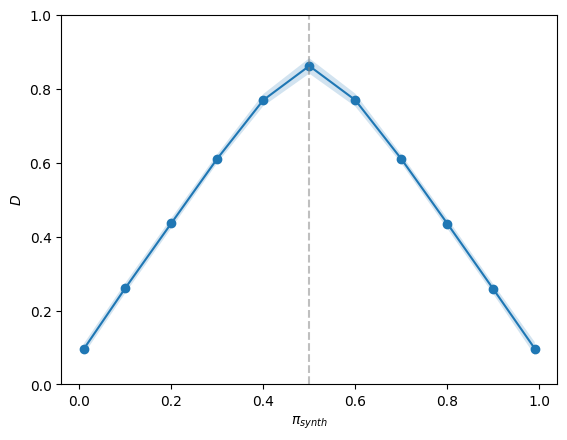

In [109]:
x = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
d = results_prop.groupby('treated %').mean()['d']
beta = results_prop.groupby('treated %').mean()['beta']
kl = results_prop.groupby('treated %').mean()['kl']
d_std = results_prop.groupby('treated %').std()['d']
beta_std = results_prop.groupby('treated %').std()['beta']
kl_std = results_prop.groupby('treated %').std()['kl']

plt.plot(x, d, 'o-', label = 'd')
#plt.plot(x, beta, label = 'beta')
#plt.plot(x, kl, label = 'kl')

plt.fill_between(x, d - d_std, d + d_std, alpha=0.2)
#plt.fill_between(x, beta - beta_std, beta + beta_std, alpha=0.2)
#plt.fill_between(x, kl - kl_std, kl + kl_std, alpha=0.2)
#plt.legend()
plt.ylim([0,1])
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('$D$')
plt.xlabel('$\pi_{synth}$')
plt.savefig('plots/propensity_metric_plot.png')

### U

In [110]:
def create_simulated_datasets(n, d, n_o, n_t, n_known, error_sd=0):
    X,y,w,p,t = simulate_treatment_setup(n, d=d, n_o=n_o, n_t=n_t, error_sd=error_sd)
    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y, columns = ['y'])
    w_df = pd.DataFrame(w, columns = ['w'])

    d_real = pd.concat([X_df,w_df,y_df], axis=1)
    d_synth = pd.concat([X_df,w_df], axis=1)

    mu0_coefs = np.ones(n_o)
    mu0 = np.dot(X[:, : n_o] ** 2, mu0_coefs)

    mu1_coefs = np.ones(n_known)
    X_sel = X[:, n_o : n_o + n_known]
    mu1 = mu0 + np.dot(X_sel**2, mu1_coefs)

    new_column_values = []
    for index, value in d_synth['w'].iteritems():
        if value == 0:
            new_column_values.append(mu0[index])
        else:
            new_column_values.append(mu1[index])

    d_synth['y'] = new_column_values

    return d_real, d_synth

In [111]:
def run_utility_exp(n, d, n_o, n_t, n_knowns, n_iter, error_sd=0):
    results = pd.DataFrame(columns=['n_known', 'u_pehe', 'u_policy', 'u_int'])
    for n_known in n_knowns:
        for _ in range(n_iter):
            d_real, d_synth = create_simulated_datasets(n, d,n_o, n_t, n_known)
            u_pehe = evaluate_u_pehe(d_real, d_synth, 'w', 'y', n_units=d)
            u_policy = evaluate_u_policy(d_real, d_synth, 'w', 'y', n_units=d)
            u_int = evaluate_u_int(d_real, d_synth, 'w', 'y', n_units=d)[0]

            results.loc[len(results)] = [n_known, u_pehe, u_policy, u_int]
            print(f'done {n_known} {_}')

    return results

In [112]:
results = run_utility_exp(1000, 10, 5, 5, [0,1,2,3,4,5], n_iter = 5)

done 0 0
done 0 1
done 0 2
done 0 3
done 0 4
done 1 0
done 1 1
done 1 2
done 1 3
done 1 4
done 2 0
done 2 1
done 2 2
done 2 3
done 2 4
done 3 0
done 3 1
done 3 2
done 3 3
done 3 4
done 4 0
done 4 1
done 4 2
done 4 3
done 4 4
done 5 0
done 5 1
done 5 2
done 5 3
done 5 4


In [113]:
results.groupby('n_known').mean()

,u_pehe,u_policy,u_int
n_known,,,
0.0,5.681611,0.397,0.112282
1.0,4.634271,0.732,0.453006
2.0,3.473935,0.811,0.631693
3.0,2.495156,0.922,0.726473
4.0,1.983456,0.957,0.849846
5.0,1.318448,0.988,0.927460


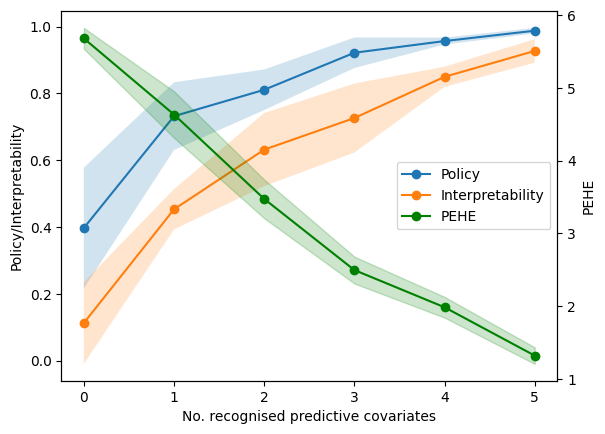

In [129]:
x = [0,1,2,3,4,5]
u_pehe = results.groupby('n_known').mean()['u_pehe']
u_policy = results.groupby('n_known').mean()['u_policy']
u_int = results.groupby('n_known').mean()['u_int']
u_pehe_std = results.groupby('n_known').std()['u_pehe']
u_policy_std = results.groupby('n_known').std()['u_policy']
u_int_std = results.groupby('n_known').std()['u_int']

fig, ax1 = plt.subplots()
ax1.plot(x, u_policy, 'o-', label = 'Policy')
ax1.plot(x, u_int, 'o-', label = 'Interpretability')
ax1.fill_between(x, u_policy - u_policy_std, u_policy + u_policy_std, alpha=0.2)
ax1.fill_between(x, u_int - u_int_std, u_int + u_int_std, alpha=0.2)
ax1.set_ylabel('Policy/Interpretability')

ax2 = ax1.twinx()
ax2.plot(x, u_pehe, 'o-', label = 'PEHE', color='g')
ax2.set_ylabel('PEHE')
ax2.fill_between(x, u_pehe - u_pehe_std, u_pehe + u_pehe_std, alpha=0.2, color='g')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1+handles2
labels=labels1+labels2

plt.legend(handles, labels, loc='center right')
ax1.set_xlabel('No. recognised predictive covariates')
plt.savefig('utility_metric_plot.png')

([<matplotlib.lines.Line2D at 0x7f49a058ab90>,
 ['policy', 'int'])

## New covariate distribution illustrative test

In [34]:
def cov_dist_illustrative(n, n_covs):
    alpha = AlphaPrecision()
    kl = InverseKLDivergence()
    mmd = MaximumMeanDiscrepancy()
    results = pd.DataFrame(columns=['n_cov', 'alpha', 'beta', 'kl', 'mmd'])
    for n_cov in n_covs:
        X, y, w, p, t = simulate_treatment_setup(n, n_cov)
        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y, columns = ['y'])
        w_df = pd.DataFrame(w, columns = ['w'])

        d_real = pd.concat([X_df,w_df,y_df], axis=1)
        d_syn = d_real.copy()
        c = d_real.drop(['w', 'y'], axis=1).columns
        d_syn[c] = 0
        results.loc[len(results)] = [n_cov, alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))['delta_precision_alpha_OC'], 
                                     alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))['delta_coverage_beta_OC'],
                                     kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))['marginal'],
                                     mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))['joint']]
    return results

In [41]:
results = cov_dist_illustrative(1000, [1,2,3,4,5,6,7,8,9,10])

In [42]:
results

,n_cov,alpha,beta,kl,mmd
0,1.0,0.896641,0.364267,0.685529,0.088571
1,2.0,0.823956,0.267933,0.527977,0.157971
2,3.0,0.749559,0.224000,0.433758,0.215335
3,4.0,0.678671,0.155133,0.370297,0.254347
4,5.0,0.736425,0.167400,0.325205,0.264557
5,6.0,0.529867,0.124067,0.291075,0.274397
6,7.0,0.629968,0.088333,0.264794,0.290047
7,8.0,0.725625,0.146133,0.244170,0.310178
8,9.0,0.699582,0.057600,0.226729,0.305175
9,10.0,0.314533,0.122867,0.212800,0.313197


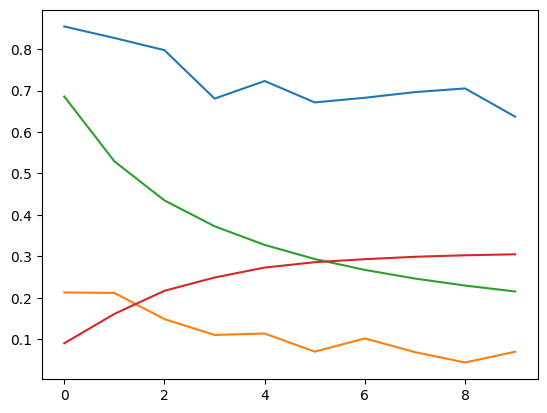

In [40]:
plt.plot(results['alpha'])
plt.plot(results['beta'])
plt.plot(results['kl'])
plt.plot(results['mmd'])

In [49]:
X, y, w, p, t = simulate_treatment_setup(1000, 2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)
c = d_real.drop(['w', 'y'], axis=1).columns
#d_real[c] *= 10

In [50]:
d_syn = d_real.copy()
d_syn['w'] = 0

In [51]:
alpha = AlphaPrecision()
kl = InverseKLDivergence()
mmd = MaximumMeanDiscrepancy()

In [52]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'delta_precision_alpha_OC': 0.5455333333333334,
 'delta_coverage_beta_OC': 0.4749977011494253,
 'authenticity_OC': 0.416,
 'delta_precision_alpha_naive': 0.9398666666666667,
 'delta_coverage_beta_naive': 0.49839999999999995,
 'authenticity_naive': 0.503}

In [53]:
kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'marginal': 0.7693872037983206}

In [54]:
mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'joint': 0.02762580954934199}

In [63]:
X, y, w, p, t = simulate_treatment_setup(1000, 2, n_t=2)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns = ['y'])
w_df = pd.DataFrame(w, columns = ['w'])

d_real = pd.concat([X_df,w_df,y_df], axis=1)
#d_real[c] *= 10

In [64]:
d_syn = pd.DataFrame(columns = d_real.columns)
d_syn[0] = d_real[0]
d_syn[1] = d_real[1]
d_syn['w'] = d_real['w']
d_syn['y'] = np.random.normal(loc = 0, size=(1000,1))

In [65]:
alpha.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'delta_precision_alpha_OC': 0.8506,
 'delta_coverage_beta_OC': 0.44566666666666654,
 'authenticity_OC': 0.604,
 'delta_precision_alpha_naive': 0.9993356321839081,
 'delta_coverage_beta_naive': 0.9993356321839081,
 'authenticity_naive': 0.0}

In [66]:
kl.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'marginal': 0.8239389674000923}

In [67]:
mmd.evaluate(GenericDataLoader(d_real), GenericDataLoader(d_syn))

{'joint': 0.00893364031042121}